In [1]:
 #@title Imports. { vertical-output: true }
from etils import epath
from ml_collections import config_dict
import numpy as np
import tensorflow as tf
import tqdm
# from src.perch.inference import colab_utils
# colab_utils.initialize(use_tf_gpu=True, disable_warnings=True)

from src.perch import audio_utils
from src.perch.inference import embed_lib
from src.perch.inference import tf_examples
import matplotlib.pyplot as plt

In [2]:
#@title Configuration. { vertical-output: true }

# Define the model
model_choice = 'perch'  #@param
model_choice = 'birdnet'  #@param

config = config_dict.ConfigDict()
config.embed_fn_config = config_dict.ConfigDict()
config.embed_fn_config.model_config = config_dict.ConfigDict()

# Pick the input and output targets.
config.source_file_patterns = ['']  #@param
config.output_dir = '/tmp/embeddings'  #@param

# For Perch, the directory containing the model.
# Alternatively, set the perch_tfhub_model_version, and the model will load
# directly from TFHub.
# Note that only one of perch_model_path and perch_tfhub_version should be set.
perch_model_path = ''  #@param
perch_tfhub_version = 2  #@param

# For BirdNET, point to the specific tflite file.
birdnet_model_path = '/Users/moritzrichert/Downloads/V2.4/BirdNET_GLOBAL_6K_V2.4_Model_FP32.tflite'  #@param
if model_choice == 'perch':
  config.embed_fn_config.model_key = 'taxonomy_model_tf'
  config.embed_fn_config.model_config.window_size_s = 5.0
  config.embed_fn_config.model_config.hop_size_s = 5.0
  config.embed_fn_config.model_config.sample_rate = 32000
  config.embed_fn_config.model_config.tfhub_version = perch_tfhub_version
  config.embed_fn_config.model_config.model_path = perch_model_path
elif model_choice == 'birdnet':
  config.embed_fn_config.model_key = 'birdnet'
  config.embed_fn_config.model_config.window_size_s = 3.0
  config.embed_fn_config.model_config.hop_size_s = 3.0
  config.embed_fn_config.model_config.sample_rate = 48000
  config.embed_fn_config.model_config.model_path = birdnet_model_path
  # Note: This class list is appropriate for Birdnet 2.1, 2.2, and 2.3
  config.embed_fn_config.model_config.class_list_name = 'birdnet_v2_4'
  config.embed_fn_config.model_config.num_tflite_threads = 4

# Only write embeddings to reduce size.
config.embed_fn_config.write_embeddings = True
config.embed_fn_config.write_logits = False
config.embed_fn_config.write_separated_audio = False
config.embed_fn_config.write_raw_audio = False


# Embedding windows are broken up into groups, typically one minute in length.
# This lets us limit input size to the model, track progres and
# recover from failures more easily.
config.shard_len_s = 60  #@param
config.num_shards_per_file = 10  #@param

# Number of parent directories to include in the filename.
config.embed_fn_config.file_id_depth = 1

# Number of TF Record files to create.
config.tf_record_shards = 10  #@param

In [3]:
import os

In [4]:
#@title Set up. { vertical-output: true }

# Set up the embedding function, including loading models.
embed_fn = embed_lib.EmbedFn(**config.embed_fn_config)
print('\n\nLoading model(s)...')
embed_fn.setup()

# Create output directory and write the configuration.
output_dir = epath.Path(config.output_dir)
output_dir.mkdir(exist_ok=True, parents=True)
embed_lib.maybe_write_config(config, output_dir)

# Create SourceInfos.
source_infos = embed_lib.create_source_infos(
    config.source_file_patterns,
    config.num_shards_per_file,
    config.shard_len_s)

print(f'Found {len(source_infos)} source infos.')
print(source_infos)
print(os.getcwd())

print('\n\nTest-run of model...')
window_size_s = config.embed_fn_config.model_config.window_size_s
sr = config.embed_fn_config.model_config.sample_rate
z = np.zeros([int(sr * window_size_s)])
test_embeds = embed_fn.embedding_model.embed(z)
print('Setup complete!')



Loading model(s)...


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


.
Found 10 source infos.
[SourceInfo(filepath='.', id=0, shard_num=0, shard_len_s=60), SourceInfo(filepath='.', id=1, shard_num=1, shard_len_s=60), SourceInfo(filepath='.', id=2, shard_num=2, shard_len_s=60), SourceInfo(filepath='.', id=3, shard_num=3, shard_len_s=60), SourceInfo(filepath='.', id=4, shard_num=4, shard_len_s=60), SourceInfo(filepath='.', id=5, shard_num=5, shard_len_s=60), SourceInfo(filepath='.', id=6, shard_num=6, shard_len_s=60), SourceInfo(filepath='.', id=7, shard_num=7, shard_len_s=60), SourceInfo(filepath='.', id=8, shard_num=8, shard_len_s=60), SourceInfo(filepath='.', id=9, shard_num=9, shard_len_s=60)]
/Users/moritzrichert/Projects/GADME-BaselineResults-BA/notebooks/Bird_Embeddings


Test-run of model...
Setup complete!


In [5]:
# lets try to load data
from src.datamodule.gadme_datamodule import GADMEDataModule
from src.datamodule.base_datamodule import DatasetConfig, LoadersConfig, LoaderConfig
from src.datamodule.components.transforms import TransformsWrapper
from src.datamodule.components.event_mapping import XCEventMapping

In [6]:
dataset_name = "DBD-research-group/gadme_v1"
cache_dir = "/Volumes/BigChongusF/Datasets/Huggingface/gadme_v1/data"
dataset_config = DatasetConfig(cache_dir, "high_sierras", dataset_name, "high_sierras", 42, 22, 3, 0.2, "multiclass")
loaders_config = LoadersConfig()
loaders_config.train = LoaderConfig(12, True, 6, True, False, True, 2)
loaders_config.valid = LoaderConfig(12, False)
loaders_config.test = LoaderConfig(12, False)
transforms_wrapper = TransformsWrapper()
mapper = XCEventMapping()
dm = GADMEDataModule(dataset_config, loaders_config, transforms_wrapper, mapper)

In [7]:
dm.prepare_data()

Saving the dataset (0/1 shards):   0%|          | 0/21650 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5413 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10296 [00:00<?, ? examples/s]

In [8]:
dm.setup("fit")

In [9]:
dm.train_dataset

Dataset({
    features: ['filepath', 'labels', 'detected_events', 'start_time', 'end_time'],
    num_rows: 21650
})

In [10]:
dm.train_dataset.to_pandas()

,filepath,labels,detected_events,start_time,end_time
0,/Volumes/BigChongusF/Datasets/Huggingface/gadm...,0,"[0.0, 3.2]",NaN,NaN
1,/Volumes/BigChongusF/Datasets/Huggingface/gadm...,0,"[16.528, 19.664]",NaN,NaN
2,/Volumes/BigChongusF/Datasets/Huggingface/gadm...,21,"[11.424, 15.024]",NaN,NaN
3,/Volumes/BigChongusF/Datasets/Huggingface/gadm...,2,"[239.232, 242.32]",NaN,NaN
4,/Volumes/BigChongusF/Datasets/Huggingface/gadm...,13,"[39.744, 40.528]",NaN,NaN
...,...,...,...,...,...
21645,/Volumes/BigChongusF/Datasets/Huggingface/gadm...,0,"[0.0, 1.456]",NaN,NaN
21646,/Volumes/BigChongusF/Datasets/Huggingface/gadm...,21,"[23.264, 25.424]",NaN,NaN
21647,/Volumes/BigChongusF/Datasets/Huggingface/gadm...,20,"[35.744, 36.496]",NaN,NaN
21648,/Volumes/BigChongusF/Datasets/Huggingface/gadm...,19,"[33.296, 34.16]",NaN,NaN


In [11]:
df = dm.train_dataset.to_pandas()
df

,filepath,labels,detected_events,start_time,end_time
0,/Volumes/BigChongusF/Datasets/Huggingface/gadm...,0,"[0.0, 3.2]",NaN,NaN
1,/Volumes/BigChongusF/Datasets/Huggingface/gadm...,0,"[16.528, 19.664]",NaN,NaN
2,/Volumes/BigChongusF/Datasets/Huggingface/gadm...,21,"[11.424, 15.024]",NaN,NaN
3,/Volumes/BigChongusF/Datasets/Huggingface/gadm...,2,"[239.232, 242.32]",NaN,NaN
4,/Volumes/BigChongusF/Datasets/Huggingface/gadm...,13,"[39.744, 40.528]",NaN,NaN
...,...,...,...,...,...
21645,/Volumes/BigChongusF/Datasets/Huggingface/gadm...,0,"[0.0, 1.456]",NaN,NaN
21646,/Volumes/BigChongusF/Datasets/Huggingface/gadm...,21,"[23.264, 25.424]",NaN,NaN
21647,/Volumes/BigChongusF/Datasets/Huggingface/gadm...,20,"[35.744, 36.496]",NaN,NaN
21648,/Volumes/BigChongusF/Datasets/Huggingface/gadm...,19,"[33.296, 34.16]",NaN,NaN


In [12]:
source_infos = []
l_df = len(df)

for i in range(l_df):
    row = df.iloc[i]
    file_name = row["filepath"]
    d_events = row["detected_events"]
    stert_time = 0
    end_time = 0
    if len(d_events) == 2:
        stert_time = d_events[0]
        end_time = d_events[1]
    
    source_infos.append(embed_lib.NewSourceInfo(file_name, stert_time, end_time))

source_infos

[NewSourceInfo(filepath='/Volumes/BigChongusF/Datasets/Huggingface/gadme_v1/data/downloads/extracted/c654a2fa7284c6b9ad2b65fb7d03c399719d51032c53323567e62583eb09dd11/data/xeno-canto/north_america/catharus_guttatus/XC691469.ogg', start_time=0.0, end_time=3.2),
 NewSourceInfo(filepath='/Volumes/BigChongusF/Datasets/Huggingface/gadme_v1/data/downloads/extracted/c8c29167330b38826de4c1aa93e6bc223fc787ef2bb38599f8079bac7568f894/data/xeno-canto/north_america/haemorhous_cassinii/XC77990.ogg', start_time=16.528, end_time=19.664),
 NewSourceInfo(filepath='/Volumes/BigChongusF/Datasets/Huggingface/gadme_v1/data/downloads/extracted/ec613fac723ec2b148b37e696a540c4078e291087c8525c0be0e654266f29161/data/xeno-canto/north_america/colaptes_auratus/XC167132.ogg', start_time=11.424, end_time=15.024),
 NewSourceInfo(filepath='/Volumes/BigChongusF/Datasets/Huggingface/gadme_v1/data/downloads/extracted/e68da0013aa2de07a892cea4436ef4f05bf18dc840e506a49e4934fad311632a/data/xeno-canto/north_america/zonotrichia_

In [13]:
df["events"] = df["detected_events"].map(lambda x : len(x))

In [14]:
len(df["filepath"].unique())

6433

In [15]:
df["events"].unique()

array([2, 0])

In [16]:
nullth = dm.train_dataset.to_pandas()["filepath"].iloc[0]
nullth

'/Volumes/BigChongusF/Datasets/Huggingface/gadme_v1/data/downloads/extracted/c654a2fa7284c6b9ad2b65fb7d03c399719d51032c53323567e62583eb09dd11/data/xeno-canto/north_america/catharus_guttatus/XC691469.ogg'

In [17]:
def file_id(file_id_depth: int, filepath:str) -> str:
    file_id = epath.Path(
        *epath.Path(filepath).parts[-(file_id_depth + 1) :]
    ).as_posix()
    return file_id

In [18]:
file_id(1, nullth)

'catharus_guttatus/XC691469.ogg'

In [19]:
file_id(0, nullth)

'XC691469.ogg'

In [20]:
from pydub import AudioSegment
import tensorflow as tf

# dataset = tf.data.Dataset.list_files('path/to/mp3s/*')


df = dm.train_dataset.to_pandas()
l_df = len(df)

filenames = []
for i in range(l_df):
    filename = df["filepath"].iloc[i]
    filenames.append(filename)

len(filenames)

21650

In [21]:
from tensorflow.python.data.ops import from_tensor_slices_op
dataset = from_tensor_slices_op._TensorSliceDataset(
filenames, is_files=True, name=None)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [22]:
def decode_mp3(mp3_path):
    mp3_path = mp3_path.numpy().decode("utf-8")
    mp3_audio = AudioSegment.from_file(mp3_path, format="ogg")
    samples = mp3_audio.get_array_of_samples()
    return samples

In [23]:
dataset = dataset.map(lambda path:tf.py_function(func=decode_mp3, inp=[path], Tout=tf.float32))

In [24]:
# parser = tf_examples.get_example_parser()

In [25]:
# dataset = dataset.map(parser)

In [26]:
dataset

<_MapDataset element_spec=TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)>

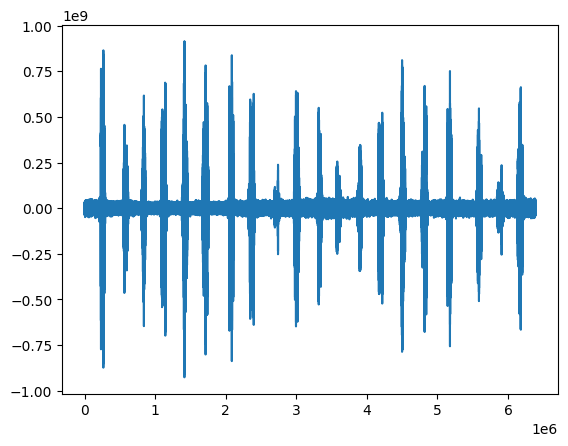

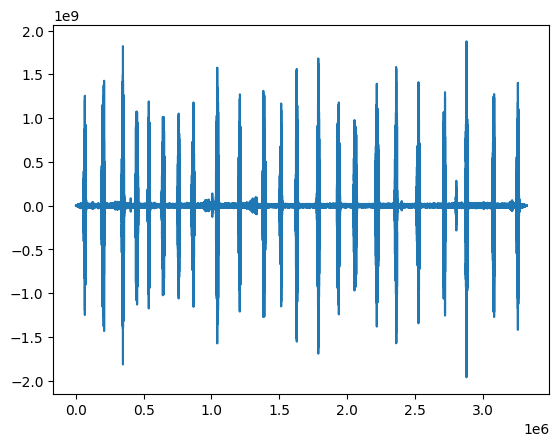

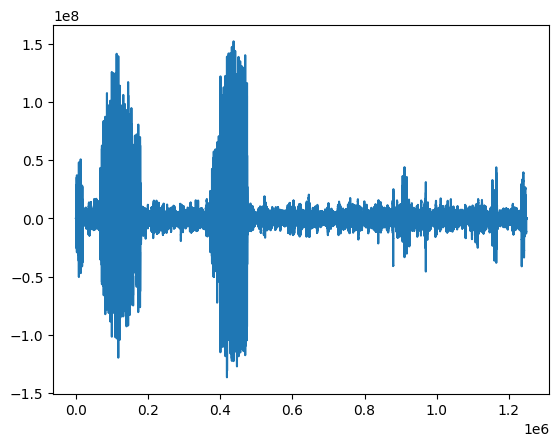

In [27]:
for features in dataset.take(3):
    data = features.numpy()
    plt.plot(data)
    plt.show()

In [28]:
# existing_source_ids = set([])

# for e in dataset.as_numpy_iterator():
#     existing_source_ids.add(
#         embed_lib.SourceId(str(e['filename'], 'UTF_8'), e['timestamp_s'])
#     )

In [29]:
output_dir

PosixGPath('/tmp/embeddings')

In [30]:
# embed_fn.min_audio_s = 1.0
# record_file = (output_dir / 'embeddings.tfrecord').as_posix()
# succ, fail = 0, 0

# existing_embedding_ids = embed_lib.get_existing_source_ids(
#     output_dir, 'embeddings-*')
# existing_embedding_ids

In [31]:
# record_file

In [32]:
# source_infos = embed_lib.get_new_source_infos(
#     source_infos, existing_embedding_ids, config.embed_fn_config.file_id_depth)

# print(f'Processing {len(source_infos)} new source infos.')

In [33]:
output_dir

PosixGPath('/tmp/embeddings')

In [34]:
config.tf_record_shards

10

In [35]:
source_infos

[NewSourceInfo(filepath='/Volumes/BigChongusF/Datasets/Huggingface/gadme_v1/data/downloads/extracted/c654a2fa7284c6b9ad2b65fb7d03c399719d51032c53323567e62583eb09dd11/data/xeno-canto/north_america/catharus_guttatus/XC691469.ogg', start_time=0.0, end_time=3.2),
 NewSourceInfo(filepath='/Volumes/BigChongusF/Datasets/Huggingface/gadme_v1/data/downloads/extracted/c8c29167330b38826de4c1aa93e6bc223fc787ef2bb38599f8079bac7568f894/data/xeno-canto/north_america/haemorhous_cassinii/XC77990.ogg', start_time=16.528, end_time=19.664),
 NewSourceInfo(filepath='/Volumes/BigChongusF/Datasets/Huggingface/gadme_v1/data/downloads/extracted/ec613fac723ec2b148b37e696a540c4078e291087c8525c0be0e654266f29161/data/xeno-canto/north_america/colaptes_auratus/XC167132.ogg', start_time=11.424, end_time=15.024),
 NewSourceInfo(filepath='/Volumes/BigChongusF/Datasets/Huggingface/gadme_v1/data/downloads/extracted/e68da0013aa2de07a892cea4436ef4f05bf18dc840e506a49e4934fad311632a/data/xeno-canto/north_america/zonotrichia_

In [ ]:
for i_info in range(10):
    source_info_i = source_infos[i_info]
    example = embed_fn.process_new_SourceInfo(source_info=source_info_i)
    print(example)

In [ ]:
for source_info in tqdm.tqdm(source_infos):
    examples = embed_fn.process_new_SourceInfo(source_info=source_info)

  0%|          | 2/21650 [00:32<114:37:27, 19.06s/it]

Handling haemorhous_cassinii/XC77990.ogg


  0%|          | 3/21650 [00:32<62:47:14, 10.44s/it] 

Handling colaptes_auratus/XC167132.ogg


  0%|          | 4/21650 [00:33<39:40:03,  6.60s/it]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC294367.ogg


  0%|          | 5/21650 [00:34<26:33:11,  4.42s/it]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC323240.ogg


  0%|          | 6/21650 [00:34<18:11:29,  3.03s/it]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC641669.ogg


  0%|          | 10/21650 [00:35<5:39:05,  1.06it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_coronata/XC799256.ogg
Handling anas_platyrhynchos/XC514863.ogg
Handling poecile_gambeli/XC368496.ogg


  0%|          | 12/21650 [00:35<3:50:59,  1.56it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC445845.ogg


  0%|          | 14/21650 [00:36<3:06:27,  1.93it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC354820.ogg
Handling turdus_migratorius/XC537999.ogg


  0%|          | 15/21650 [00:36<2:33:57,  2.34it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC221602.ogg


  0%|          | 17/21650 [00:36<1:46:00,  3.40it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC172994.ogg


  0%|          | 23/21650 [00:36<53:30,  6.74it/s]  

Handling junco_hyemalis/XC445568.ogg
Handling catharus_guttatus/XC22067.ogg


Handling turdus_migratorius/XC322567.ogg


  0%|          | 26/21650 [00:37<1:16:46,  4.69it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC149907.ogg
Handling zonotrichia_leucophrys/XC111747.ogg


  0%|          | 29/21650 [00:38<1:25:40,  4.21it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC479796.ogg


  0%|          | 31/21650 [00:39<1:29:36,  4.02it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC205538.ogg
Handling setophaga_petechia/XC488442.ogg


  0%|          | 34/21650 [00:39<58:51,  6.12it/s]  WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC111745.ogg


  0%|          | 38/21650 [00:39<45:31,  7.91it/s]  WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC423450.ogg
Handling junco_hyemalis/XC71990.ogg


Handling turdus_migratorius/XC713003.ogg


  0%|          | 41/21650 [00:40<57:48,  6.23it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC628047.ogg


  0%|          | 42/21650 [00:40<1:03:10,  5.70it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC192188.ogg
Handling zonotrichia_leucophrys/XC621441.ogg


  0%|          | 47/21650 [00:41<46:12,  7.79it/s]  WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC535166.ogg
Handling junco_hyemalis/XC149907.ogg


  0%|          | 51/21650 [00:41<30:59, 11.62it/s]

Handling catharus_guttatus/XC779667.ogg


Handling vireo_gilvus/XC323462.ogg


  0%|          | 53/21650 [00:44<2:19:19,  2.58it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_coronata/XC535227.ogg


Handling colaptes_auratus/XC583816.ogg


  0%|          | 55/21650 [00:44<2:10:27,  2.76it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC159081.ogg
Handling anas_platyrhynchos/XC453926.ogg


  0%|          | 60/21650 [00:45<1:18:13,  4.60it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC113828.ogg
Handling vireo_gilvus/XC78104.ogg
Handling zonotrichia_leucophrys/XC173161.ogg


  0%|          | 62/21650 [00:45<1:04:01,  5.62it/s]WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC561906.ogg
Handling poecile_gambeli/XC369972.ogg


  0%|          | 64/21650 [00:46<1:31:06,  3.95it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC615193.ogg


  0%|          | 65/21650 [00:46<1:41:42,  3.54it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC628049.ogg
Handling anas_platyrhynchos/XC464826.ogg


  0%|          | 68/21650 [00:47<1:15:04,  4.79it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC125776.ogg
Handling turdus_migratorius/XC160752.ogg


  0%|          | 70/21650 [00:47<1:05:00,  5.53it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC391012.ogg


  0%|          | 77/21650 [00:47<35:03, 10.26it/s]  WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC102949.ogg
Handling anas_platyrhynchos/XC776376.ogg
Handling setophaga_petechia/XC335045.ogg


  0%|          | 79/21650 [00:47<32:44, 10.98it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC556938.ogg


Handling vireo_gilvus/XC804066.ogg


  0%|          | 81/21650 [00:48<58:30,  6.14it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC561073.ogg
Handling anas_platyrhynchos/XC343370.ogg


  0%|          | 83/21650 [00:48<58:05,  6.19it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC272305.ogg
Handling zonotrichia_leucophrys/XC692530.ogg


  0%|          | 87/21650 [00:49<57:54,  6.21it/s]  

Handling passerella_iliaca/XC713325.ogg
Handling turdus_migratorius/XC646526.ogg
Handling colaptes_auratus/XC622237.ogg


  0%|          | 90/21650 [00:49<44:17,  8.11it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC461342.ogg
Handling vireo_gilvus/XC161973.ogg


Handling turdus_migratorius/XC610883.ogg


  0%|          | 92/21650 [00:50<1:07:48,  5.30it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC221613.ogg
Handling anthus_rubescens/XC760994.ogg


  0%|          | 94/21650 [00:51<1:25:42,  4.19it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC678158.ogg


  0%|          | 95/21650 [00:51<1:26:41,  4.14it/s]WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC110021.ogg


  0%|          | 98/21650 [00:52<1:41:10,  3.55it/s]

Handling setophaga_coronata/XC188141.ogg
Handling colaptes_auratus/XC248138.ogg


  0%|          | 99/21650 [00:54<3:06:10,  1.93it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC350723.ogg


  0%|          | 100/21650 [00:54<3:32:47,  1.69it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC294460.ogg


  0%|          | 102/21650 [00:55<2:36:43,  2.29it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC189056.ogg


  0%|          | 104/21650 [00:55<2:06:54,  2.83it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC777542.ogg
Handling turdus_migratorius/XC482331.ogg
Handling leucosticte_tephrocotis/XC143943.ogg


  0%|          | 106/21650 [00:56<1:58:13,  3.04it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC733270.ogg


  0%|          | 108/21650 [00:56<1:39:37,  3.60it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC718210.ogg
Handling anthus_rubescens/XC451883.ogg


  1%|          | 113/21650 [00:57<44:16,  8.11it/s]  

Handling junco_hyemalis/XC729535.ogg
Handling poecile_gambeli/XC224195.ogg
Handling vireo_gilvus/XC776678.ogg


Handling poecile_gambeli/XC71785.ogg


  1%|          | 115/21650 [00:58<1:28:27,  4.06it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC358193.ogg


  1%|          | 116/21650 [00:58<1:27:44,  4.09it/s]WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC381716.ogg


  1%|          | 117/21650 [00:59<2:18:38,  2.59it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC394597.ogg


  1%|          | 120/21650 [01:00<1:40:46,  3.56it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC143211.ogg
Handling vireo_gilvus/XC156191.ogg


  1%|          | 122/21650 [01:01<2:06:43,  2.83it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC394593.ogg


  1%|          | 126/21650 [01:01<1:15:06,  4.78it/s]WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC299264.ogg
Handling zonotrichia_leucophrys/XC86105.ogg
Handling colaptes_auratus/XC140990.ogg
Handling vireo_gilvus/XC709999.ogg


  1%|          | 128/21650 [01:01<1:00:40,  5.91it/s]WARNING:absl:Audio loaded successfully.


Handling euphagus_cyanocephalus/XC749022.ogg


Handling passerella_iliaca/XC439916.ogg


  1%|          | 131/21650 [01:02<1:07:10,  5.34it/s]

Handling turdus_migratorius/XC660898.ogg
Handling poecile_gambeli/XC22061.ogg


  1%|          | 134/21650 [01:03<1:46:49,  3.36it/s]WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC593554.ogg
Handling catharus_guttatus/XC303606.ogg


  1%|          | 135/21650 [01:03<1:34:02,  3.81it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC125768.ogg


  1%|          | 136/21650 [01:04<1:36:22,  3.72it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC536943.ogg


  1%|          | 138/21650 [01:04<1:15:53,  4.72it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC141221.ogg
Handling junco_hyemalis/XC371883.ogg


  1%|          | 143/21650 [01:04<38:36,  9.28it/s]  WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC236401.ogg
Handling anas_platyrhynchos/XC633453.ogg
Handling anas_platyrhynchos/XC25746.ogg


  1%|          | 145/21650 [01:05<51:15,  6.99it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC14230.ogg
Handling catharus_guttatus/XC370755.ogg


  1%|          | 147/21650 [01:05<50:30,  7.10it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC182085.ogg


  1%|          | 150/21650 [01:05<50:05,  7.15it/s]WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC137558.ogg
Handling anas_platyrhynchos/XC720205.ogg
Handling anas_platyrhynchos/XC447481.ogg


  1%|          | 153/21650 [01:06<39:31,  9.07it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC157622.ogg


  1%|          | 155/21650 [01:06<46:28,  7.71it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC160003.ogg


  1%|          | 159/21650 [01:07<53:06,  6.74it/s]WARNING:absl:Audio loaded successfully.


Handling actitis_macularius/XC139722.ogg


  1%|          | 162/21650 [01:07<53:31,  6.69it/s]

Handling anas_platyrhynchos/XC717928.ogg
Handling euphagus_cyanocephalus/XC205761.ogg


  1%|          | 163/21650 [01:07<1:02:47,  5.70it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC253844.ogg


  1%|          | 164/21650 [01:08<1:06:54,  5.35it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC172408.ogg


  1%|          | 165/21650 [01:08<1:12:24,  4.95it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC356605.ogg


  1%|          | 167/21650 [01:08<1:01:04,  5.86it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC535139.ogg


  1%|          | 169/21650 [01:09<1:26:47,  4.12it/s]

Handling anas_platyrhynchos/XC131955.ogg
Handling turdus_migratorius/XC160800.ogg


  1%|          | 170/21650 [01:09<1:16:29,  4.68it/s]WARNING:absl:Audio loaded successfully.


Handling sialia_currucoides/XC420507.ogg


  1%|          | 172/21650 [01:10<1:56:51,  3.06it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC149321.ogg


  1%|          | 174/21650 [01:11<1:57:25,  3.05it/s]

Handling turdus_migratorius/XC269081.ogg
Handling catharus_guttatus/XC181478.ogg


  1%|          | 177/21650 [01:11<1:20:55,  4.42it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC511284.ogg
Handling passerella_iliaca/XC406245.ogg


  1%|          | 179/21650 [01:12<1:20:20,  4.45it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC283379.ogg


  1%|          | 180/21650 [01:12<1:28:53,  4.03it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC104584.ogg


  1%|          | 181/21650 [01:12<1:30:34,  3.95it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_coronata/XC378355.ogg
Handling junco_hyemalis/XC542391.ogg


  1%|          | 183/21650 [01:13<1:18:08,  4.58it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC192496.ogg
Handling euphagus_cyanocephalus/XC408610.ogg


  1%|          | 185/21650 [01:14<2:19:38,  2.56it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC737159.ogg


  1%|          | 187/21650 [01:14<1:57:40,  3.04it/s]

Handling zonotrichia_leucophrys/XC535266.ogg
Handling setophaga_petechia/XC572425.ogg


  1%|          | 188/21650 [01:15<2:14:11,  2.67it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC298773.ogg


  1%|          | 192/21650 [01:16<1:22:56,  4.31it/s]

Handling catharus_guttatus/XC152404.ogg
Handling setophaga_coronata/XC353483.ogg
Handling colaptes_auratus/XC313675.ogg
Handling turdus_migratorius/XC628190.ogg


  1%|          | 193/21650 [01:16<1:18:08,  4.58it/s]WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC149347.ogg


  1%|          | 195/21650 [01:17<1:28:49,  4.03it/s]

Handling leiothlypis_celata/XC90149.ogg
Handling colaptes_auratus/XC159057.ogg


  1%|          | 198/21650 [01:17<54:55,  6.51it/s]  WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC408589.ogg
Handling catharus_guttatus/XC326278.ogg


  1%|          | 200/21650 [01:17<47:39,  7.50it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC665812.ogg


  1%|          | 202/21650 [01:18<1:32:25,  3.87it/s]

Handling zonotrichia_leucophrys/XC535276.ogg
Handling catharus_guttatus/XC211426.ogg


  1%|          | 203/21650 [01:18<1:34:28,  3.78it/s]

Handling vireo_gilvus/XC575828.ogg


  1%|          | 204/21650 [01:23<8:12:50,  1.38s/it]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC653780.ogg


  1%|          | 205/21650 [01:23<6:22:37,  1.07s/it]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC425118.ogg


  1%|          | 207/21650 [01:24<4:19:08,  1.38it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC89170.ogg
Handling catharus_guttatus/XC323230.ogg


Handling empidonax_oberholseri/XC193117.ogg


  1%|          | 209/21650 [01:25<3:14:47,  1.83it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC113817.ogg


  1%|          | 210/21650 [01:25<3:28:25,  1.71it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC227274.ogg


  1%|          | 211/21650 [01:26<3:33:42,  1.67it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC535290.ogg


  1%|          | 212/21650 [01:26<2:58:07,  2.01it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC124486.ogg


  1%|          | 215/21650 [01:27<1:33:11,  3.83it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC177502.ogg
Handling nucifraga_columbiana/XC451197.ogg


  1%|          | 218/21650 [01:27<1:02:43,  5.70it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC99379.ogg


  1%|          | 221/21650 [01:27<55:10,  6.47it/s]  WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC780172.ogg
Handling setophaga_coronata/XC729517.ogg


  1%|          | 225/21650 [01:27<32:20, 11.04it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC777543.ogg
Handling colaptes_auratus/XC368592.ogg


  1%|          | 227/21650 [01:28<33:35, 10.63it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC328324.ogg


  1%|          | 230/21650 [01:28<31:00, 11.51it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC14295.ogg


  1%|          | 232/21650 [01:29<1:06:27,  5.37it/s]

Handling salpinctes_obsoletus/XC233381.ogg
Handling zonotrichia_leucophrys/XC353606.ogg


  1%|          | 234/21650 [01:29<1:02:48,  5.68it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC107861.ogg


  1%|          | 238/21650 [01:29<46:00,  7.76it/s]  WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC551539.ogg
Handling leiothlypis_celata/XC344650.ogg


  1%|          | 240/21650 [01:30<43:18,  8.24it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC603651.ogg
Handling anas_platyrhynchos/XC434854.ogg


  1%|          | 242/21650 [01:31<1:18:12,  4.56it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC535275.ogg
Handling junco_hyemalis/XC313196.ogg


  1%|          | 246/21650 [01:31<1:05:31,  5.44it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC71835.ogg
Handling junco_hyemalis/XC669690.ogg


  1%|          | 250/21650 [01:32<58:55,  6.05it/s]  WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC373771.ogg
Handling anas_platyrhynchos/XC358493.ogg
Handling anas_platyrhynchos/XC297303.ogg


  1%|          | 255/21650 [01:32<42:24,  8.41it/s]

Handling leiothlypis_celata/XC747206.ogg
Handling anas_platyrhynchos/XC297305.ogg
Handling catharus_guttatus/XC323231.ogg


Handling turdus_migratorius/XC406163.ogg


  1%|          | 259/21650 [01:33<46:06,  7.73it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC804242.ogg
Handling colaptes_auratus/XC638937.ogg
Handling junco_hyemalis/XC309041.ogg
Handling passerella_iliaca/XC188500.ogg


  1%|          | 262/21650 [01:35<1:53:11,  3.15it/s]WARNING:absl:Audio loaded successfully.


Handling nucifraga_columbiana/XC629536.ogg


  1%|          | 263/21650 [01:35<1:48:00,  3.30it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC680492.ogg
Handling anas_platyrhynchos/XC436930.ogg


  1%|          | 265/21650 [01:35<1:43:07,  3.46it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_coronata/XC469599.ogg


  1%|          | 267/21650 [01:36<1:37:19,  3.66it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC379158.ogg
Handling vireo_gilvus/XC323458.ogg


  1%|          | 269/21650 [01:36<1:19:48,  4.46it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC729485.ogg
Handling salpinctes_obsoletus/XC315322.ogg


  1%|▏         | 272/21650 [01:37<1:14:26,  4.79it/s]

Handling catharus_guttatus/XC488923.ogg
Handling catharus_guttatus/XC149586.ogg


  1%|▏         | 275/21650 [01:37<52:24,  6.80it/s]  WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC22036.ogg


  1%|▏         | 279/21650 [01:38<42:25,  8.40it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC780172.ogg
Handling anas_platyrhynchos/XC464827.ogg
Handling turdus_migratorius/XC452609.ogg


  1%|▏         | 283/21650 [01:38<36:25,  9.78it/s]

Handling passerella_iliaca/XC420222.ogg
Handling zonotrichia_leucophrys/XC558354.ogg


  1%|▏         | 287/21650 [01:38<31:30, 11.30it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC743168.ogg
Handling vireo_gilvus/XC481120.ogg


Handling vireo_gilvus/XC672702.ogg


  1%|▏         | 289/21650 [01:39<41:58,  8.48it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC125772.ogg
Handling passerella_iliaca/XC426064.ogg


  1%|▏         | 292/21650 [01:39<35:19, 10.08it/s]WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC620784.ogg
Handling vireo_gilvus/XC159382.ogg


  1%|▏         | 294/21650 [01:39<55:31,  6.41it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC404744.ogg
Handling junco_hyemalis/XC487484.ogg


  1%|▏         | 297/21650 [01:40<1:16:38,  4.64it/s]

Handling vireo_gilvus/XC672702.ogg
Handling vireo_gilvus/XC103099.ogg


  1%|▏         | 298/21650 [01:41<1:26:45,  4.10it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC727745.ogg


  1%|▏         | 299/21650 [01:41<1:46:42,  3.33it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC26966.ogg


  1%|▏         | 300/21650 [01:42<1:53:49,  3.13it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC605589.ogg
Handling poecile_gambeli/XC256763.ogg


  1%|▏         | 303/21650 [01:44<2:47:31,  2.12it/s]

Handling anthus_rubescens/XC277562.ogg
Handling colaptes_auratus/XC292299.ogg


  1%|▏         | 305/21650 [01:48<6:08:29,  1.04s/it]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC566394.ogg
Handling setophaga_petechia/XC332397.ogg


  1%|▏         | 307/21650 [01:48<3:42:15,  1.60it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC735578.ogg
Handling turdus_migratorius/XC686190.ogg
Handling colaptes_auratus/XC292299.ogg
Handling actitis_macularius/XC88799.ogg


  1%|▏         | 310/21650 [01:48<2:06:24,  2.81it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC533315.ogg
Handling colaptes_auratus/XC31518.ogg


  1%|▏         | 312/21650 [01:48<1:45:11,  3.38it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC629681.ogg


  1%|▏         | 313/21650 [01:49<2:12:01,  2.69it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC253586.ogg


  1%|▏         | 314/21650 [01:49<2:03:30,  2.88it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC803999.ogg
Handling setophaga_coronata/XC309929.ogg


  1%|▏         | 317/21650 [01:50<1:29:51,  3.96it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC21286.ogg
Handling vireo_gilvus/XC151606.ogg
Handling colaptes_auratus/XC122615.ogg


  1%|▏         | 320/21650 [01:50<1:07:13,  5.29it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC71812.ogg
Handling catharus_guttatus/XC495506.ogg


  1%|▏         | 322/21650 [01:50<51:18,  6.93it/s]  WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC225578.ogg
Handling turdus_migratorius/XC492775.ogg


  1%|▏         | 324/21650 [01:51<56:20,  6.31it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC34823.ogg
Handling catharus_guttatus/XC348962.ogg
Handling colaptes_auratus/XC410727.ogg


Handling leiothlypis_celata/XC289370.ogg


  2%|▏         | 327/21650 [01:51<1:05:34,  5.42it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC467695.ogg


  2%|▏         | 330/21650 [01:52<58:12,  6.10it/s]  WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC325009.ogg
Handling setophaga_coronata/XC78029.ogg


  2%|▏         | 333/21650 [01:52<45:34,  7.79it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC733271.ogg
Handling zonotrichia_leucophrys/XC611728.ogg
Handling vireo_gilvus/XC232123.ogg


  2%|▏         | 335/21650 [01:52<51:50,  6.85it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC729486.ogg


  2%|▏         | 337/21650 [01:53<1:07:46,  5.24it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC175239.ogg


  2%|▏         | 340/21650 [01:53<55:35,  6.39it/s]  WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC158956.ogg


  2%|▏         | 342/21650 [01:54<1:02:15,  5.70it/s]

Handling leiothlypis_celata/XC302646.ogg
Handling anthus_rubescens/XC448720.ogg


  2%|▏         | 343/21650 [01:54<1:08:46,  5.16it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC777542.ogg


  2%|▏         | 345/21650 [01:55<1:28:39,  4.01it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC792210.ogg
Handling junco_hyemalis/XC567901.ogg


  2%|▏         | 346/21650 [01:55<1:32:26,  3.84it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC774434.ogg


  2%|▏         | 348/21650 [01:56<1:26:28,  4.11it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC149906.ogg
Handling turdus_migratorius/XC459052.ogg


  2%|▏         | 350/21650 [01:56<1:25:31,  4.15it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC421273.ogg


  2%|▏         | 352/21650 [01:56<1:08:28,  5.18it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC285315.ogg


  2%|▏         | 354/21650 [01:57<1:44:15,  3.40it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC89170.ogg


  2%|▏         | 355/21650 [01:57<1:42:22,  3.47it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC573271.ogg


  2%|▏         | 356/21650 [01:58<1:54:49,  3.09it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC535286.ogg


  2%|▏         | 358/21650 [01:59<1:53:43,  3.12it/s]

Handling anas_platyrhynchos/XC609373.ogg
Handling junco_hyemalis/XC582574.ogg


  2%|▏         | 360/21650 [01:59<2:00:18,  2.95it/s]WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC351164.ogg
Handling junco_hyemalis/XC171280.ogg


  2%|▏         | 363/21650 [02:00<1:14:13,  4.78it/s]

Handling actitis_macularius/XC371207.ogg
Handling turdus_migratorius/XC302644.ogg


  2%|▏         | 367/21650 [02:00<53:17,  6.66it/s]  WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC415746.ogg
Handling euphagus_cyanocephalus/XC585732.ogg
Handling leiothlypis_celata/XC561363.ogg


  2%|▏         | 369/21650 [02:00<43:01,  8.24it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC373781.ogg


  2%|▏         | 371/21650 [02:01<41:05,  8.63it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC449507.ogg
Handling nucifraga_columbiana/XC538964.ogg


  2%|▏         | 374/21650 [02:01<44:47,  7.92it/s]WARNING:absl:Audio loaded successfully.


Handling nucifraga_columbiana/XC417735.ogg
Handling anas_platyrhynchos/XC666547.ogg
Handling anthus_rubescens/XC620542.ogg


  2%|▏         | 377/21650 [02:01<42:07,  8.42it/s]WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC517454.ogg


  2%|▏         | 380/21650 [02:02<49:07,  7.22it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC630758.ogg


  2%|▏         | 383/21650 [02:02<50:22,  7.04it/s]  WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC104584.ogg
Handling vireo_gilvus/XC661363.ogg
Handling anas_platyrhynchos/XC373788.ogg
Handling catharus_guttatus/XC14210.ogg


  2%|▏         | 385/21650 [02:03<45:51,  7.73it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC729934.ogg
Handling turdus_migratorius/XC738573.ogg


  2%|▏         | 390/21650 [02:03<40:13,  8.81it/s]

Handling zonotrichia_leucophrys/XC111735.ogg
Handling junco_hyemalis/XC606100.ogg


  2%|▏         | 392/21650 [02:03<39:33,  8.96it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_coronata/XC244402.ogg
Handling salpinctes_obsoletus/XC229181.ogg


  2%|▏         | 394/21650 [02:04<41:00,  8.64it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_coronata/XC644168.ogg
Handling turdus_migratorius/XC803375.ogg


  2%|▏         | 395/21650 [02:04<44:07,  8.03it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC351974.ogg


  2%|▏         | 397/21650 [02:04<50:07,  7.07it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC542618.ogg
Handling sialia_currucoides/XC77995.ogg
Handling anas_platyrhynchos/XC613584.ogg


  2%|▏         | 400/21650 [02:04<41:31,  8.53it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC323681.ogg
Handling junco_hyemalis/XC368608.ogg


  2%|▏         | 402/21650 [02:05<42:31,  8.33it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC365736.ogg


  2%|▏         | 404/21650 [02:05<55:43,  6.35it/s]

Handling junco_hyemalis/XC76620.ogg
Handling catharus_guttatus/XC144107.ogg


  2%|▏         | 406/21650 [02:06<1:22:17,  4.30it/s]

Handling haemorhous_cassinii/XC551536.ogg
Handling haemorhous_cassinii/XC71809.ogg


  2%|▏         | 407/21650 [02:06<1:37:45,  3.62it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC636627.ogg


  2%|▏         | 408/21650 [02:07<1:35:27,  3.71it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC494197.ogg


  2%|▏         | 409/21650 [02:07<1:47:38,  3.29it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC165295.ogg


  2%|▏         | 414/21650 [02:07<50:51,  6.96it/s]  WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC482696.ogg
Handling anas_platyrhynchos/XC495824.ogg
Handling anas_platyrhynchos/XC717931.ogg


  2%|▏         | 416/21650 [02:08<48:23,  7.31it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC206101.ogg
Handling junco_hyemalis/XC199215.ogg


  2%|▏         | 420/21650 [02:08<43:59,  8.04it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC582728.ogg
Handling actitis_macularius/XC422425.ogg


  2%|▏         | 423/21650 [02:08<37:36,  9.41it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC720920.ogg


Handling turdus_migratorius/XC172823.ogg


  2%|▏         | 425/21650 [02:09<59:58,  5.90it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC777433.ogg


  2%|▏         | 429/21650 [02:10<51:57,  6.81it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC700539.ogg
Handling zonotrichia_leucophrys/XC114666.ogg


  2%|▏         | 431/21650 [02:10<49:50,  7.10it/s]

Handling turdus_migratorius/XC626745.ogg
Handling setophaga_petechia/XC407127.ogg


  2%|▏         | 432/21650 [02:11<1:24:26,  4.19it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC540531.ogg


  2%|▏         | 433/21650 [02:11<1:29:35,  3.95it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC134500.ogg


  2%|▏         | 434/21650 [02:11<1:40:00,  3.54it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_coronata/XC640361.ogg


  2%|▏         | 437/21650 [02:12<1:18:20,  4.51it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC110573.ogg
Handling turdus_migratorius/XC377115.ogg


  2%|▏         | 442/21650 [02:12<50:07,  7.05it/s]  WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC558332.ogg
Handling anas_platyrhynchos/XC560160.ogg
Handling leiothlypis_celata/XC683408.ogg


  2%|▏         | 443/21650 [02:12<50:40,  6.97it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC199950.ogg
Handling colaptes_auratus/XC79670.ogg


  2%|▏         | 448/21650 [02:13<35:26,  9.97it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC599316.ogg
Handling turdus_migratorius/XC322884.ogg
Handling vireo_gilvus/XC733271.ogg


  2%|▏         | 450/21650 [02:14<1:36:41,  3.65it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC262842.ogg


  2%|▏         | 451/21650 [02:15<2:06:23,  2.80it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC299732.ogg


  2%|▏         | 453/21650 [02:16<2:06:43,  2.79it/s]WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC123850.ogg
Handling leiothlypis_celata/XC683408.ogg


Handling catharus_guttatus/XC138247.ogg


  2%|▏         | 458/21650 [02:16<1:00:23,  5.85it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC351834.ogg
Handling turdus_migratorius/XC159905.ogg


  2%|▏         | 460/21650 [02:16<49:28,  7.14it/s]  WARNING:absl:Audio loaded successfully.


Handling leucosticte_tephrocotis/XC352925.ogg
Handling colaptes_auratus/XC337472.ogg


  2%|▏         | 463/21650 [02:17<53:14,  6.63it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC771919.ogg


  2%|▏         | 465/21650 [02:17<1:01:31,  5.74it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC224196.ogg
Handling junco_hyemalis/XC269463.ogg


Handling actitis_macularius/XC480225.ogg


  2%|▏         | 471/21650 [02:18<49:21,  7.15it/s]  WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC53784.ogg
Handling nucifraga_columbiana/XC105326.ogg
Handling turdus_migratorius/XC476984.ogg


  2%|▏         | 475/21650 [02:19<50:42,  6.96it/s]WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC571045.ogg


  2%|▏         | 478/21650 [02:19<51:30,  6.85it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC224196.ogg


  2%|▏         | 479/21650 [02:19<57:52,  6.10it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC322798.ogg


  2%|▏         | 482/21650 [02:20<53:02,  6.65it/s]  WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC535282.ogg
Handling haemorhous_cassinii/XC551515.ogg
Handling turdus_migratorius/XC131093.ogg
Handling catharus_guttatus/XC187622.ogg


  2%|▏         | 484/21650 [02:20<1:10:22,  5.01it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC192496.ogg


  2%|▏         | 486/21650 [02:21<1:37:03,  3.63it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC172996.ogg
Handling vireo_gilvus/XC501583.ogg
Handling colaptes_auratus/XC661731.ogg


  2%|▏         | 488/21650 [02:22<1:19:29,  4.44it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC80751.ogg


  2%|▏         | 491/21650 [02:22<1:03:07,  5.59it/s]

Handling junco_hyemalis/XC125078.ogg
Handling actitis_macularius/XC31323.ogg
Handling setophaga_petechia/XC32085.ogg


  2%|▏         | 493/21650 [02:22<1:05:25,  5.39it/s]

Handling junco_hyemalis/XC561763.ogg
Handling turdus_migratorius/XC785958.ogg


  2%|▏         | 496/21650 [02:23<44:45,  7.88it/s]  WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC146165.ogg
Handling junco_hyemalis/XC104586.ogg
Handling junco_hyemalis/XC135547.ogg
Handling setophaga_coronata/XC504133.ogg


  2%|▏         | 499/21650 [02:23<31:31, 11.18it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC369900.ogg
Handling junco_hyemalis/XC473419.ogg


  2%|▏         | 501/21650 [02:24<1:36:50,  3.64it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC234171.ogg
Handling turdus_migratorius/XC114083.ogg


  2%|▏         | 506/21650 [02:25<55:59,  6.29it/s]  

Handling colaptes_auratus/XC141866.ogg
Handling leiothlypis_celata/XC178855.ogg


  2%|▏         | 512/21650 [02:25<42:08,  8.36it/s]  

Handling anas_platyrhynchos/XC601748.ogg
Handling anas_platyrhynchos/XC123501.ogg


Handling zonotrichia_leucophrys/XC725965.ogg


  2%|▏         | 514/21650 [02:26<1:19:37,  4.42it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC703742.ogg


  2%|▏         | 516/21650 [02:27<1:19:14,  4.44it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC413534.ogg
Handling junco_hyemalis/XC477131.ogg


  2%|▏         | 518/21650 [02:28<1:46:29,  3.31it/s]

Handling catharus_guttatus/XC298746.ogg
Handling zonotrichia_leucophrys/XC184231.ogg


  2%|▏         | 521/21650 [02:28<1:22:01,  4.29it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC785275.ogg
Handling zonotrichia_leucophrys/XC353606.ogg


Handling actitis_macularius/XC322582.ogg


  2%|▏         | 524/21650 [02:29<1:15:33,  4.66it/s]WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC196938.ogg
Handling colaptes_auratus/XC768332.ogg


  2%|▏         | 527/21650 [02:29<55:23,  6.36it/s]  WARNING:absl:Audio loaded successfully.


Handling euphagus_cyanocephalus/XC764037.ogg


  2%|▏         | 531/21650 [02:30<57:20,  6.14it/s]

Handling passerella_iliaca/XC157764.ogg
Handling salpinctes_obsoletus/XC554608.ogg


  2%|▏         | 534/21650 [02:30<55:46,  6.31it/s]  WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC571054.ogg
Handling turdus_migratorius/XC779497.ogg
Handling actitis_macularius/XC453000.ogg


  2%|▏         | 536/21650 [02:31<1:02:34,  5.62it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC157770.ogg
Handling anas_platyrhynchos/XC217664.ogg


  2%|▏         | 539/21650 [02:32<1:12:28,  4.85it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC160197.ogg


  3%|▎         | 542/21650 [02:32<1:16:42,  4.59it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC381590.ogg
Handling nucifraga_columbiana/XC451196.ogg


  3%|▎         | 546/21650 [02:33<47:47,  7.36it/s]  WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC124643.ogg
Handling zonotrichia_leucophrys/XC54713.ogg


  3%|▎         | 548/21650 [02:33<45:19,  7.76it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC323637.ogg


  3%|▎         | 549/21650 [02:33<1:01:56,  5.68it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC449495.ogg


  3%|▎         | 550/21650 [02:33<1:05:21,  5.38it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC71773.ogg


  3%|▎         | 553/21650 [02:34<1:08:55,  5.10it/s]

Handling vireo_gilvus/XC749756.ogg
Handling zonotrichia_leucophrys/XC678160.ogg


  3%|▎         | 554/21650 [02:34<1:16:04,  4.62it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC165287.ogg


  3%|▎         | 556/21650 [02:35<1:01:02,  5.76it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC729933.ogg


  3%|▎         | 558/21650 [02:38<4:23:15,  1.34it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC495822.ogg
Handling anas_platyrhynchos/XC635041.ogg


  3%|▎         | 560/21650 [02:38<3:09:08,  1.86it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC72964.ogg


  3%|▎         | 561/21650 [02:39<2:51:37,  2.05it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC225409.ogg


  3%|▎         | 564/21650 [02:39<1:44:44,  3.36it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC309639.ogg


  3%|▎         | 567/21650 [02:39<1:21:18,  4.32it/s]

Handling salpinctes_obsoletus/XC139877.ogg
Handling junco_hyemalis/XC727505.ogg


  3%|▎         | 569/21650 [02:39<1:03:13,  5.56it/s]WARNING:absl:Audio loaded successfully.


Handling sialia_currucoides/XC453336.ogg
Handling turdus_migratorius/XC172423.ogg


  3%|▎         | 570/21650 [02:40<1:01:17,  5.73it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC325252.ogg
Handling haemorhous_cassinii/XC408589.ogg


  3%|▎         | 574/21650 [02:40<44:09,  7.95it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC599651.ogg
Handling zonotrichia_leucophrys/XC313078.ogg


  3%|▎         | 577/21650 [02:40<31:33, 11.13it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC135136.ogg
Handling leiothlypis_celata/XC54118.ogg


  3%|▎         | 581/21650 [02:41<34:39, 10.13it/s]WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC554608.ogg
Handling anas_platyrhynchos/XC693028.ogg
Handling poecile_gambeli/XC350737.ogg


  3%|▎         | 583/21650 [02:41<45:15,  7.76it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC164441.ogg
Handling vireo_gilvus/XC181169.ogg


  3%|▎         | 585/21650 [02:41<37:15,  9.42it/s]WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC451709.ogg
Handling leiothlypis_celata/XC636627.ogg


  3%|▎         | 587/21650 [02:41<38:39,  9.08it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC157764.ogg
Handling haemorhous_cassinii/XC14420.ogg


  3%|▎         | 594/21650 [02:42<30:58, 11.33it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC182397.ogg
Handling poecile_gambeli/XC390195.ogg
Handling sialia_currucoides/XC254429.ogg


  3%|▎         | 596/21650 [02:42<37:39,  9.32it/s]

Handling euphagus_cyanocephalus/XC30587.ogg
Handling junco_hyemalis/XC628056.ogg


  3%|▎         | 598/21650 [02:42<34:39, 10.12it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_coronata/XC551319.ogg
Handling anas_platyrhynchos/XC628151.ogg


Handling junco_hyemalis/XC71998.ogg


  3%|▎         | 604/21650 [02:43<32:35, 10.76it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC494197.ogg
Handling poecile_gambeli/XC402984.ogg


Handling setophaga_coronata/XC164304.ogg


  3%|▎         | 606/21650 [02:44<48:19,  7.26it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC731832.ogg


Handling vireo_gilvus/XC323442.ogg


  3%|▎         | 610/21650 [02:45<1:13:33,  4.77it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC535268.ogg
Handling turdus_migratorius/XC110565.ogg


  3%|▎         | 612/21650 [02:45<1:04:17,  5.45it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC208945.ogg
Handling vireo_gilvus/XC501581.ogg
Handling poecile_gambeli/XC38011.ogg


  3%|▎         | 614/21650 [02:46<1:07:56,  5.16it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC521582.ogg
Handling zonotrichia_leucophrys/XC159016.ogg


  3%|▎         | 617/21650 [02:46<1:10:12,  4.99it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC190473.ogg
Handling vireo_gilvus/XC421861.ogg


Handling leiothlypis_celata/XC159087.ogg


  3%|▎         | 620/21650 [02:47<1:08:52,  5.09it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC452956.ogg


  3%|▎         | 622/21650 [02:47<1:01:25,  5.71it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC111743.ogg


  3%|▎         | 624/21650 [02:48<1:04:20,  5.45it/s]

Handling vireo_gilvus/XC323454.ogg
Handling colaptes_auratus/XC31177.ogg


  3%|▎         | 626/21650 [02:48<55:48,  6.28it/s]  WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC326838.ogg
Handling vireo_gilvus/XC177838.ogg


  3%|▎         | 628/21650 [02:48<49:27,  7.09it/s]WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC680003.ogg


  3%|▎         | 631/21650 [02:49<53:32,  6.54it/s]  WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC777433.ogg
Handling colaptes_auratus/XC495961.ogg


  3%|▎         | 633/21650 [02:49<51:33,  6.79it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC721103.ogg


  3%|▎         | 635/21650 [02:50<1:24:33,  4.14it/s]

Handling turdus_migratorius/XC752950.ogg
Handling catharus_guttatus/XC135069.ogg


  3%|▎         | 637/21650 [02:51<1:42:37,  3.41it/s]

Handling vireo_gilvus/XC484140.ogg
Handling nucifraga_columbiana/XC422415.ogg


  3%|▎         | 638/21650 [02:51<1:50:12,  3.18it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC323250.ogg


  3%|▎         | 639/21650 [02:52<3:01:13,  1.93it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC189063.ogg


  3%|▎         | 641/21650 [02:52<2:11:48,  2.66it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC612894.ogg
Handling nucifraga_columbiana/XC570306.ogg


  3%|▎         | 643/21650 [02:53<1:22:53,  4.22it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC358196.ogg


  3%|▎         | 645/21650 [02:53<1:08:42,  5.10it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC160571.ogg


  3%|▎         | 647/21650 [02:53<1:11:46,  4.88it/s]

Handling turdus_migratorius/XC205803.ogg
Handling passerella_iliaca/XC535177.ogg


  3%|▎         | 648/21650 [02:54<1:53:55,  3.07it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC159442.ogg
Handling turdus_migratorius/XC158960.ogg


  3%|▎         | 651/21650 [02:55<1:28:35,  3.95it/s]

Handling actitis_macularius/XC637899.ogg
Handling vireo_gilvus/XC349070.ogg


  3%|▎         | 652/21650 [02:55<1:34:02,  3.72it/s]

Handling junco_hyemalis/XC628049.ogg


  3%|▎         | 653/21650 [02:56<3:08:35,  1.86it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC574479.ogg


  3%|▎         | 655/21650 [02:56<2:10:07,  2.69it/s]WARNING:absl:Audio loaded successfully.


Handling nucifraga_columbiana/XC294244.ogg


  3%|▎         | 656/21650 [02:57<1:57:54,  2.97it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC464841.ogg


  3%|▎         | 657/21650 [02:57<2:13:42,  2.62it/s]WARNING:absl:Audio loaded successfully.


Handling nucifraga_columbiana/XC102879.ogg


  3%|▎         | 658/21650 [02:58<2:08:21,  2.73it/s]WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC13624.ogg


  3%|▎         | 659/21650 [02:58<2:34:11,  2.27it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC113828.ogg


  3%|▎         | 662/21650 [02:59<2:09:48,  2.69it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC72287.ogg


  3%|▎         | 663/21650 [03:00<2:21:27,  2.47it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC253538.ogg


  3%|▎         | 665/21650 [03:00<1:52:21,  3.11it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC322572.ogg
Handling poecile_gambeli/XC221616.ogg


  3%|▎         | 667/21650 [03:00<1:30:05,  3.88it/s]WARNING:absl:Audio loaded successfully.


Handling nucifraga_columbiana/XC578100.ogg
Handling setophaga_coronata/XC135646.ogg


  3%|▎         | 669/21650 [03:01<1:07:24,  5.19it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC424298.ogg
Handling passerella_iliaca/XC253955.ogg


  3%|▎         | 670/21650 [03:01<1:04:09,  5.45it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC224192.ogg


  3%|▎         | 674/21650 [03:01<45:16,  7.72it/s]  

Handling setophaga_coronata/XC135917.ogg
Handling colaptes_auratus/XC465729.ogg


  3%|▎         | 676/21650 [03:02<1:04:05,  5.45it/s]WARNING:absl:Audio loaded successfully.


Handling nucifraga_columbiana/XC105324.ogg
Handling turdus_migratorius/XC362515.ogg


  3%|▎         | 677/21650 [03:02<1:05:34,  5.33it/s]WARNING:absl:Audio loaded successfully.


Handling euphagus_cyanocephalus/XC752807.ogg
Handling anas_platyrhynchos/XC750475.ogg
Handling nucifraga_columbiana/XC182587.ogg


  3%|▎         | 682/21650 [03:03<46:08,  7.57it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC177469.ogg
Handling colaptes_auratus/XC618043.ogg


  3%|▎         | 689/21650 [03:03<23:49, 14.67it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC379007.ogg
Handling anas_platyrhynchos/XC122883.ogg
Handling leiothlypis_celata/XC349484.ogg


  3%|▎         | 693/21650 [03:03<27:32, 12.68it/s]

Handling poecile_gambeli/XC350719.ogg
Handling junco_hyemalis/XC125074.ogg
Handling haemorhous_cassinii/XC220514.ogg


  3%|▎         | 695/21650 [03:03<27:30, 12.70it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC76625.ogg
Handling vireo_gilvus/XC383037.ogg
Handling turdus_migratorius/XC253216.ogg


  3%|▎         | 698/21650 [03:04<25:30, 13.69it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC139086.ogg


  3%|▎         | 703/21650 [03:05<42:53,  8.14it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC787153.ogg
Handling turdus_migratorius/XC729486.ogg


Handling leiothlypis_celata/XC323042.ogg


  3%|▎         | 705/21650 [03:06<1:15:09,  4.65it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC175222.ogg
Handling empidonax_oberholseri/XC110022.ogg


  3%|▎         | 708/21650 [03:06<1:09:03,  5.05it/s]WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC124625.ogg


  3%|▎         | 711/21650 [03:07<1:11:13,  4.90it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC269454.ogg
Handling vireo_gilvus/XC321950.ogg


  3%|▎         | 713/21650 [03:07<1:01:25,  5.68it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC612894.ogg


  3%|▎         | 714/21650 [03:07<1:08:30,  5.09it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC135816.ogg


  3%|▎         | 716/21650 [03:08<1:29:47,  3.89it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC141868.ogg


  3%|▎         | 718/21650 [03:09<2:04:04,  2.81it/s]

Handling passerella_iliaca/XC188504.ogg


  3%|▎         | 719/21650 [03:11<3:41:30,  1.57it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC445847.ogg
Handling anas_platyrhynchos/XC25717.ogg


  3%|▎         | 721/21650 [03:12<3:22:56,  1.72it/s]WARNING:absl:Audio loaded successfully.


Handling nucifraga_columbiana/XC294270.ogg


  3%|▎         | 723/21650 [03:12<2:32:18,  2.29it/s]

Handling turdus_migratorius/XC158033.ogg


  3%|▎         | 725/21650 [03:14<2:53:33,  2.01it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC394596.ogg
Handling poecile_gambeli/XC647144.ogg


  3%|▎         | 726/21650 [03:14<2:29:20,  2.34it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_coronata/XC364122.ogg


  3%|▎         | 727/21650 [03:14<2:12:45,  2.63it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC601482.ogg


  3%|▎         | 729/21650 [03:14<1:33:15,  3.74it/s]WARNING:absl:Audio loaded successfully.


Handling anthus_rubescens/XC14085.ogg


  3%|▎         | 731/21650 [03:15<1:15:18,  4.63it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC184972.ogg
Handling zonotrichia_leucophrys/XC535277.ogg


  3%|▎         | 733/21650 [03:15<53:34,  6.51it/s]  

Handling turdus_migratorius/XC103199.ogg


  3%|▎         | 735/21650 [03:16<2:09:49,  2.68it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC188503.ogg
Handling leucosticte_tephrocotis/XC101456.ogg


Handling anas_platyrhynchos/XC646375.ogg


  3%|▎         | 739/21650 [03:17<1:34:22,  3.69it/s]

Handling euphagus_cyanocephalus/XC377880.ogg
Handling junco_hyemalis/XC172994.ogg


Handling vireo_gilvus/XC195841.ogg


  3%|▎         | 744/21650 [03:18<1:04:06,  5.43it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC190473.ogg
Handling turdus_migratorius/XC252953.ogg
Handling colaptes_auratus/XC253572.ogg


Handling turdus_migratorius/XC160752.ogg


  3%|▎         | 748/21650 [03:19<56:57,  6.12it/s]  

Handling turdus_migratorius/XC642934.ogg
Handling poecile_gambeli/XC634928.ogg
Handling poecile_gambeli/XC368496.ogg


  3%|▎         | 749/21650 [03:19<1:22:12,  4.24it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC368608.ogg


  3%|▎         | 750/21650 [03:20<1:25:45,  4.06it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC160326.ogg


  3%|▎         | 753/21650 [03:20<1:19:50,  4.36it/s]

Handling passerella_iliaca/XC508242.ogg
Handling catharus_guttatus/XC571860.ogg


  3%|▎         | 754/21650 [03:21<2:01:31,  2.87it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC278273.ogg


  3%|▎         | 756/21650 [03:21<1:37:34,  3.57it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC160599.ogg
Handling zonotrichia_leucophrys/XC721103.ogg


  4%|▎         | 758/21650 [03:22<1:21:54,  4.25it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC575614.ogg
Handling junco_hyemalis/XC147747.ogg


  4%|▎         | 762/21650 [03:22<59:03,  5.89it/s]  WARNING:absl:Audio loaded successfully.


Handling euphagus_cyanocephalus/XC30587.ogg
Handling setophaga_coronata/XC69913.ogg


  4%|▎         | 764/21650 [03:23<1:10:46,  4.92it/s]

Handling haemorhous_cassinii/XC798954.ogg
Handling haemorhous_cassinii/XC21834.ogg


  4%|▎         | 766/21650 [03:24<2:17:28,  2.53it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC394594.ogg
Handling turdus_migratorius/XC323246.ogg
Handling poecile_gambeli/XC350704.ogg


  4%|▎         | 774/21650 [03:25<38:02,  9.14it/s]  

Handling zonotrichia_leucophrys/XC159170.ogg
Handling zonotrichia_leucophrys/XC558111.ogg


Handling setophaga_coronata/XC535215.ogg


  4%|▎         | 776/21650 [03:26<1:44:02,  3.34it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC564489.ogg
Handling actitis_macularius/XC531820.ogg


  4%|▎         | 778/21650 [03:27<1:32:15,  3.77it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_coronata/XC798976.ogg
Handling turdus_migratorius/XC729486.ogg


  4%|▎         | 782/21650 [03:27<1:11:26,  4.87it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC375901.ogg
Handling catharus_guttatus/XC130244.ogg


  4%|▎         | 785/21650 [03:28<59:45,  5.82it/s]  WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC601507.ogg


  4%|▎         | 787/21650 [03:28<1:03:40,  5.46it/s]

Handling turdus_migratorius/XC468353.ogg
Handling vireo_gilvus/XC500121.ogg


  4%|▎         | 791/21650 [03:28<41:43,  8.33it/s]  WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC356605.ogg
Handling sialia_currucoides/XC477814.ogg


Handling poecile_gambeli/XC221604.ogg


  4%|▎         | 794/21650 [03:30<1:16:19,  4.55it/s]

Handling junco_hyemalis/XC373791.ogg
Handling turdus_migratorius/XC325909.ogg


  4%|▎         | 796/21650 [03:30<1:12:27,  4.80it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC14080.ogg
Handling vireo_gilvus/XC189078.ogg


  4%|▎         | 800/21650 [03:31<1:10:35,  4.92it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC236243.ogg
Handling turdus_migratorius/XC472299.ogg


  4%|▎         | 804/21650 [03:31<51:06,  6.80it/s]  WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC293630.ogg
Handling empidonax_oberholseri/XC124639.ogg
Handling setophaga_coronata/XC254320.ogg


  4%|▎         | 805/21650 [03:31<57:03,  6.09it/s]WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC769225.ogg
Handling colaptes_auratus/XC636522.ogg


  4%|▎         | 809/21650 [03:33<1:18:36,  4.42it/s]

Handling turdus_migratorius/XC165312.ogg
Handling actitis_macularius/XC157635.ogg
Handling vireo_gilvus/XC157622.ogg


  4%|▎         | 811/21650 [03:34<1:35:53,  3.62it/s]

Handling zonotrichia_leucophrys/XC575062.ogg
Handling vireo_gilvus/XC729477.ogg


  4%|▍         | 812/21650 [03:34<1:37:28,  3.56it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC125078.ogg
Handling colaptes_auratus/XC92958.ogg


  4%|▍         | 815/21650 [03:34<1:12:02,  4.82it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC374629.ogg
Handling empidonax_oberholseri/XC33848.ogg


  4%|▍         | 817/21650 [03:35<1:04:44,  5.36it/s]WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC110017.ogg


  4%|▍         | 818/21650 [03:35<1:11:50,  4.83it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC111222.ogg


  4%|▍         | 820/21650 [03:36<1:26:13,  4.03it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC574482.ogg
Handling haemorhous_cassinii/XC369970.ogg


  4%|▍         | 823/21650 [03:36<55:25,  6.26it/s]  WARNING:absl:Audio loaded successfully.


Handling euphagus_cyanocephalus/XC585732.ogg
Handling salpinctes_obsoletus/XC109272.ogg


  4%|▍         | 826/21650 [03:36<42:50,  8.10it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC785409.ogg


  4%|▍         | 829/21650 [03:37<56:35,  6.13it/s]  

Handling vireo_gilvus/XC191065.ogg
Handling poecile_gambeli/XC71774.ogg
Handling vireo_gilvus/XC568593.ogg


  4%|▍         | 832/21650 [03:37<57:26,  6.04it/s]  WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC218070.ogg
Handling zonotrichia_leucophrys/XC135685.ogg


  4%|▍         | 835/21650 [03:38<1:00:29,  5.73it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC165310.ogg


  4%|▍         | 838/21650 [03:38<57:27,  6.04it/s]  WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC187620.ogg
Handling turdus_migratorius/XC462677.ogg


  4%|▍         | 840/21650 [03:39<1:05:02,  5.33it/s]

Handling junco_hyemalis/XC72004.ogg
Handling anas_platyrhynchos/XC297304.ogg


  4%|▍         | 841/21650 [03:41<3:33:10,  1.63it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC535274.ogg
Handling turdus_migratorius/XC160805.ogg


  4%|▍         | 844/21650 [03:43<3:26:52,  1.68it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC441339.ogg
Handling setophaga_coronata/XC78057.ogg


  4%|▍         | 846/21650 [03:43<2:17:50,  2.52it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC253335.ogg
Handling haemorhous_cassinii/XC551542.ogg


  4%|▍         | 848/21650 [03:43<1:43:47,  3.34it/s]

Handling poecile_gambeli/XC578078.ogg
Handling junco_hyemalis/XC474561.ogg


  4%|▍         | 849/21650 [03:44<2:48:10,  2.06it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC323235.ogg


  4%|▍         | 852/21650 [03:45<1:41:01,  3.43it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC137067.ogg


  4%|▍         | 853/21650 [03:45<1:40:19,  3.45it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC256088.ogg


  4%|▍         | 855/21650 [03:45<1:17:01,  4.50it/s]WARNING:absl:Audio loaded successfully.


Handling leucosticte_tephrocotis/XC143942.ogg


  4%|▍         | 856/21650 [03:46<1:42:26,  3.38it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC535172.ogg


  4%|▍         | 859/21650 [03:46<1:19:29,  4.36it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC71818.ogg
Handling anas_platyrhynchos/XC550748.ogg
Handling passerella_iliaca/XC216728.ogg


  4%|▍         | 861/21650 [03:46<1:01:25,  5.64it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC71834.ogg


  4%|▍         | 862/21650 [03:47<2:03:50,  2.80it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC700531.ogg
Handling euphagus_cyanocephalus/XC348979.ogg


  4%|▍         | 864/21650 [03:48<1:35:54,  3.61it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC550438.ogg


  4%|▍         | 865/21650 [03:48<1:52:35,  3.08it/s]

Handling anas_platyrhynchos/XC701580.ogg


  4%|▍         | 867/21650 [03:50<2:31:50,  2.28it/s]WARNING:absl:Audio loaded successfully.


Handling nucifraga_columbiana/XC743105.ogg
Handling anas_platyrhynchos/XC774997.ogg


  4%|▍         | 868/21650 [03:50<2:03:13,  2.81it/s]

Handling anas_platyrhynchos/XC777648.ogg


  4%|▍         | 869/21650 [03:51<3:28:56,  1.66it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC193152.ogg


  4%|▍         | 873/21650 [03:52<1:45:46,  3.27it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC71847.ogg
Handling nucifraga_columbiana/XC408597.ogg


  4%|▍         | 875/21650 [03:52<1:26:40,  3.99it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC637875.ogg


  4%|▍         | 877/21650 [03:52<1:16:12,  4.54it/s]

Handling leiothlypis_celata/XC314849.ogg
Handling colaptes_auratus/XC347999.ogg


  4%|▍         | 879/21650 [03:53<1:38:29,  3.51it/s]

Handling turdus_migratorius/XC663100.ogg
Handling leucosticte_tephrocotis/XC432028.ogg


Handling zonotrichia_leucophrys/XC432599.ogg


  4%|▍         | 881/21650 [03:54<1:28:34,  3.91it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC31169.ogg


  4%|▍         | 883/21650 [03:54<1:16:27,  4.53it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC95321.ogg


  4%|▍         | 886/21650 [03:54<1:05:46,  5.26it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC393131.ogg
Handling vireo_gilvus/XC381167.ogg
Handling passerella_iliaca/XC291255.ogg


  4%|▍         | 888/21650 [03:55<54:51,  6.31it/s]  WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC292066.ogg
Handling junco_hyemalis/XC206101.ogg


Handling junco_hyemalis/XC138151.ogg


  4%|▍         | 895/21650 [03:55<38:29,  8.99it/s]  WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC423448.ogg
Handling anas_platyrhynchos/XC534730.ogg
Handling anas_platyrhynchos/XC706430.ogg


Handling catharus_guttatus/XC691467.ogg


  4%|▍         | 899/21650 [03:56<51:45,  6.68it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC542843.ogg
Handling anas_platyrhynchos/XC90579.ogg
Handling turdus_migratorius/XC710116.ogg


Handling anas_platyrhynchos/XC437738.ogg


  4%|▍         | 901/21650 [03:57<49:41,  6.96it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC362897.ogg


  4%|▍         | 903/21650 [03:58<1:22:19,  4.20it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC649654.ogg


  4%|▍         | 907/21650 [03:58<1:05:09,  5.31it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC534402.ogg
Handling vireo_gilvus/XC483712.ogg
Handling empidonax_oberholseri/XC124643.ogg


  4%|▍         | 909/21650 [03:58<57:31,  6.01it/s]  WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC478421.ogg
Handling vireo_gilvus/XC700129.ogg


  4%|▍         | 910/21650 [03:58<55:56,  6.18it/s]

Handling turdus_migratorius/XC734182.ogg


  4%|▍         | 911/21650 [04:00<2:44:38,  2.10it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC323235.ogg


  4%|▍         | 913/21650 [04:00<2:00:38,  2.86it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC305129.ogg
Handling junco_hyemalis/XC362895.ogg


  4%|▍         | 914/21650 [04:01<1:46:19,  3.25it/s]WARNING:absl:Audio loaded successfully.


Handling euphagus_cyanocephalus/XC159782.ogg


  4%|▍         | 915/21650 [04:01<1:48:30,  3.18it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC169594.ogg


  4%|▍         | 918/21650 [04:01<1:05:38,  5.26it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC69996.ogg


  4%|▍         | 919/21650 [04:01<1:11:36,  4.83it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC90149.ogg


  4%|▍         | 921/21650 [04:02<1:07:34,  5.11it/s]

Handling colaptes_auratus/XC323227.ogg
Handling anas_platyrhynchos/XC557184.ogg


  4%|▍         | 922/21650 [04:02<1:42:10,  3.38it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC639716.ogg


  4%|▍         | 923/21650 [04:03<1:52:38,  3.07it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC489339.ogg


  4%|▍         | 926/21650 [04:04<1:28:58,  3.88it/s]

Handling catharus_guttatus/XC122005.ogg
Handling anthus_rubescens/XC674783.ogg
Handling junco_hyemalis/XC363228.ogg


  4%|▍         | 928/21650 [04:04<1:20:06,  4.31it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC322918.ogg
Handling leiothlypis_celata/XC448943.ogg


  4%|▍         | 936/21650 [04:04<26:59, 12.79it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC265053.ogg
Handling leiothlypis_celata/XC808323.ogg


Handling poecile_gambeli/XC381389.ogg


  4%|▍         | 939/21650 [04:06<1:09:25,  4.97it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC551000.ogg


  4%|▍         | 941/21650 [04:06<1:15:07,  4.59it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC323459.ogg
Handling poecile_gambeli/XC570965.ogg


  4%|▍         | 943/21650 [04:07<1:11:56,  4.80it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC125765.ogg
Handling leiothlypis_celata/XC291616.ogg


  4%|▍         | 944/21650 [04:07<1:14:19,  4.64it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC323031.ogg


  4%|▍         | 945/21650 [04:07<1:17:59,  4.42it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC97494.ogg


  4%|▍         | 946/21650 [04:07<1:19:38,  4.33it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC663096.ogg


  4%|▍         | 947/21650 [04:08<1:37:10,  3.55it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC163135.ogg


  4%|▍         | 950/21650 [04:08<1:05:05,  5.30it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC419787.ogg
Handling vireo_gilvus/XC426270.ogg


  4%|▍         | 951/21650 [04:08<1:00:16,  5.72it/s]WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC781684.ogg


  4%|▍         | 955/21650 [04:09<40:46,  8.46it/s]  WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC727744.ogg
Handling passerella_iliaca/XC416063.ogg


  4%|▍         | 958/21650 [04:09<41:45,  8.26it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC129801.ogg
Handling junco_hyemalis/XC104587.ogg
Handling leiothlypis_celata/XC408280.ogg


  4%|▍         | 960/21650 [04:09<43:14,  7.97it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC575613.ogg
Handling vireo_gilvus/XC69966.ogg


  4%|▍         | 962/21650 [04:12<2:53:15,  1.99it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC139633.ogg


  4%|▍         | 966/21650 [04:12<1:45:29,  3.27it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC160324.ogg


  4%|▍         | 968/21650 [04:13<1:35:45,  3.60it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC606101.ogg
Handling anas_platyrhynchos/XC768200.ogg


  4%|▍         | 973/21650 [04:13<50:02,  6.89it/s]  

Handling vireo_gilvus/XC72283.ogg
Handling junco_hyemalis/XC319370.ogg


  5%|▍         | 975/21650 [04:14<1:12:53,  4.73it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC622240.ogg
Handling turdus_migratorius/XC83722.ogg


  5%|▍         | 977/21650 [04:14<1:02:13,  5.54it/s]WARNING:absl:Audio loaded successfully.


Handling euphagus_cyanocephalus/XC319246.ogg


Handling junco_hyemalis/XC408653.ogg


  5%|▍         | 980/21650 [04:15<1:16:12,  4.52it/s]

Handling anas_platyrhynchos/XC734953.ogg
Handling empidonax_oberholseri/XC190996.ogg


  5%|▍         | 982/21650 [04:15<1:15:40,  4.55it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC375894.ogg
Handling turdus_migratorius/XC67401.ogg
Handling anas_platyrhynchos/XC390377.ogg


  5%|▍         | 986/21650 [04:16<43:45,  7.87it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC71773.ogg
Handling setophaga_coronata/XC364595.ogg


Handling anas_platyrhynchos/XC755991.ogg


  5%|▍         | 991/21650 [04:17<58:07,  5.92it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC321994.ogg


  5%|▍         | 993/21650 [04:17<1:00:06,  5.73it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC553413.ogg
Handling anas_platyrhynchos/XC431624.ogg


  5%|▍         | 995/21650 [04:18<1:36:19,  3.57it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC322037.ogg
Handling junco_hyemalis/XC146596.ogg


  5%|▍         | 997/21650 [04:18<1:17:38,  4.43it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC177478.ogg
Handling vireo_gilvus/XC611814.ogg


  5%|▍         | 999/21650 [04:19<1:06:30,  5.18it/s]WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC13624.ogg


  5%|▍         | 1000/21650 [04:19<1:37:42,  3.52it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC121434.ogg


  5%|▍         | 1001/21650 [04:20<1:55:38,  2.98it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC72002.ogg


  5%|▍         | 1002/21650 [04:20<1:48:37,  3.17it/s]WARNING:absl:Audio loaded successfully.


Handling anthus_rubescens/XC387537.ogg


  5%|▍         | 1004/21650 [04:20<1:26:13,  3.99it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_coronata/XC13585.ogg


  5%|▍         | 1005/21650 [04:21<1:45:56,  3.25it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC211201.ogg
Handling junco_hyemalis/XC321210.ogg


  5%|▍         | 1008/21650 [04:22<1:43:23,  3.33it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_coronata/XC644169.ogg


  5%|▍         | 1009/21650 [04:22<2:06:39,  2.72it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC790939.ogg


  5%|▍         | 1011/21650 [04:23<1:37:06,  3.54it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC416083.ogg


  5%|▍         | 1014/21650 [04:23<1:15:17,  4.57it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC323230.ogg
Handling setophaga_coronata/XC70999.ogg


  5%|▍         | 1015/21650 [04:23<1:08:06,  5.05it/s]WARNING:absl:Audio loaded successfully.


Handling nucifraga_columbiana/XC422415.ogg


  5%|▍         | 1017/21650 [04:24<1:04:45,  5.31it/s]WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC146200.ogg
Handling vireo_gilvus/XC107861.ogg


  5%|▍         | 1018/21650 [04:24<1:02:36,  5.49it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC793410.ogg


  5%|▍         | 1020/21650 [04:25<1:30:32,  3.80it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC714328.ogg


  5%|▍         | 1021/21650 [04:25<1:53:10,  3.04it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC351969.ogg


  5%|▍         | 1023/21650 [04:26<1:58:51,  2.89it/s]WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC104639.ogg


  5%|▍         | 1024/21650 [04:26<2:02:06,  2.82it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC322838.ogg


  5%|▍         | 1027/21650 [04:27<1:18:50,  4.36it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC405020.ogg
Handling turdus_migratorius/XC171881.ogg


  5%|▍         | 1029/21650 [04:27<1:18:19,  4.39it/s]

Handling setophaga_petechia/XC661440.ogg
Handling turdus_migratorius/XC375006.ogg


  5%|▍         | 1030/21650 [04:28<2:43:42,  2.10it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC804223.ogg


  5%|▍         | 1032/21650 [04:29<2:16:09,  2.52it/s]WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC374032.ogg
Handling vireo_gilvus/XC321776.ogg


  5%|▍         | 1034/21650 [04:29<1:28:24,  3.89it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC114090.ogg
Handling junco_hyemalis/XC554504.ogg


  5%|▍         | 1036/21650 [04:30<1:39:14,  3.46it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC165272.ogg


  5%|▍         | 1037/21650 [04:30<1:44:41,  3.28it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC179098.ogg
Handling anas_platyrhynchos/XC678785.ogg


  5%|▍         | 1039/21650 [04:30<1:19:37,  4.31it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC66261.ogg


  5%|▍         | 1041/21650 [04:31<1:31:06,  3.77it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC138136.ogg
Handling haemorhous_cassinii/XC71827.ogg


  5%|▍         | 1043/21650 [04:31<1:05:51,  5.21it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC601607.ogg
Handling turdus_migratorius/XC306932.ogg


  5%|▍         | 1045/21650 [04:32<1:05:02,  5.28it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC195597.ogg


  5%|▍         | 1046/21650 [04:32<1:07:08,  5.11it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC71822.ogg


  5%|▍         | 1047/21650 [04:32<1:07:37,  5.08it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC72000.ogg


  5%|▍         | 1049/21650 [04:33<1:20:33,  4.26it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC165347.ogg
Handling junco_hyemalis/XC408768.ogg


  5%|▍         | 1050/21650 [04:33<1:20:21,  4.27it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC624993.ogg


  5%|▍         | 1051/21650 [04:33<1:41:45,  3.37it/s]WARNING:absl:Audio loaded successfully.


Handling actitis_macularius/XC183591.ogg


  5%|▍         | 1052/21650 [04:34<3:02:03,  1.89it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC550996.ogg


  5%|▍         | 1053/21650 [04:35<2:40:06,  2.14it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC465001.ogg


  5%|▍         | 1054/21650 [04:36<3:33:43,  1.61it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC135092.ogg


  5%|▍         | 1057/21650 [04:37<2:34:42,  2.22it/s]

Handling vireo_gilvus/XC321964.ogg
Handling junco_hyemalis/XC371883.ogg


  5%|▍         | 1058/21650 [04:37<2:35:43,  2.20it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC163653.ogg


  5%|▍         | 1060/21650 [04:38<1:51:10,  3.09it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC78015.ogg


  5%|▍         | 1063/21650 [04:38<1:11:21,  4.81it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC579973.ogg


  5%|▍         | 1064/21650 [04:38<1:27:51,  3.90it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC192886.ogg
Handling actitis_macularius/XC255373.ogg


  5%|▍         | 1070/21650 [04:39<45:26,  7.55it/s]  

Handling vireo_gilvus/XC662193.ogg
Handling anas_platyrhynchos/XC360300.ogg
Handling anas_platyrhynchos/XC775321.ogg


Handling vireo_gilvus/XC323680.ogg


  5%|▍         | 1072/21650 [04:40<1:18:21,  4.38it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC322033.ogg


  5%|▍         | 1074/21650 [04:40<1:10:53,  4.84it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC220515.ogg


  5%|▍         | 1075/21650 [04:40<1:12:22,  4.74it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_coronata/XC692222.ogg


  5%|▍         | 1076/21650 [04:41<1:31:50,  3.73it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_petechia/XC451089.ogg


  5%|▍         | 1077/21650 [04:41<1:54:41,  2.99it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC269455.ogg


  5%|▍         | 1080/21650 [04:42<1:13:04,  4.69it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC315611.ogg
Handling anas_platyrhynchos/XC25746.ogg
Handling zonotrichia_leucophrys/XC129781.ogg


  5%|▍         | 1082/21650 [04:43<1:53:28,  3.02it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_coronata/XC269066.ogg
Handling turdus_migratorius/XC322973.ogg


  5%|▌         | 1084/21650 [04:43<1:48:41,  3.15it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC157883.ogg


  5%|▌         | 1085/21650 [04:44<1:48:09,  3.17it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC248138.ogg


  5%|▌         | 1087/21650 [04:44<1:29:23,  3.83it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC535280.ogg


  5%|▌         | 1089/21650 [04:45<1:31:17,  3.75it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC225381.ogg


  5%|▌         | 1091/21650 [04:45<1:27:58,  3.90it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC71784.ogg
Handling anas_platyrhynchos/XC23521.ogg


  5%|▌         | 1093/21650 [04:45<1:08:10,  5.03it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC206100.ogg
Handling junco_hyemalis/XC657208.ogg
Handling zonotrichia_leucophrys/XC798837.ogg


  5%|▌         | 1095/21650 [04:46<1:00:32,  5.66it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC353544.ogg
Handling anas_platyrhynchos/XC392206.ogg


  5%|▌         | 1098/21650 [04:46<1:07:36,  5.07it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC289053.ogg
Handling zonotrichia_leucophrys/XC750611.ogg


Handling turdus_migratorius/XC295837.ogg


  5%|▌         | 1101/21650 [04:47<55:09,  6.21it/s]  WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC236241.ogg


  5%|▌         | 1102/21650 [04:47<1:00:04,  5.70it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC353500.ogg
Handling setophaga_coronata/XC384561.ogg


  5%|▌         | 1104/21650 [04:47<56:05,  6.10it/s]  WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC691467.ogg


  5%|▌         | 1106/21650 [04:48<1:26:14,  3.97it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC535281.ogg
Handling catharus_guttatus/XC576845.ogg


  5%|▌         | 1108/21650 [04:48<1:16:34,  4.47it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC637919.ogg


  5%|▌         | 1111/21650 [04:49<1:01:22,  5.58it/s]

Handling vireo_gilvus/XC169024.ogg
Handling junco_hyemalis/XC14233.ogg
Handling zonotrichia_leucophrys/XC316001.ogg


  5%|▌         | 1115/21650 [04:49<57:28,  5.96it/s]  WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC336948.ogg
Handling leiothlypis_celata/XC360344.ogg


  5%|▌         | 1119/21650 [04:50<45:12,  7.57it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC252166.ogg
Handling junco_hyemalis/XC14233.ogg
Handling anas_platyrhynchos/XC776862.ogg


  5%|▌         | 1122/21650 [04:50<43:16,  7.91it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC551505.ogg
Handling anas_platyrhynchos/XC53854.ogg


  5%|▌         | 1124/21650 [04:50<38:39,  8.85it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC58547.ogg


  5%|▌         | 1125/21650 [04:51<1:00:57,  5.61it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC323462.ogg


  5%|▌         | 1128/21650 [04:51<53:23,  6.41it/s]  WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC125079.ogg
Handling poecile_gambeli/XC619846.ogg


  5%|▌         | 1129/21650 [04:51<56:53,  6.01it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC111751.ogg
Handling catharus_guttatus/XC66033.ogg


  5%|▌         | 1131/21650 [04:52<1:00:13,  5.68it/s]WARNING:absl:Audio loaded successfully.


Handling anthus_rubescens/XC111040.ogg


  5%|▌         | 1134/21650 [04:52<53:58,  6.34it/s]  

Handling junco_hyemalis/XC269055.ogg
Handling anas_platyrhynchos/XC464843.ogg


  5%|▌         | 1135/21650 [04:53<1:10:18,  4.86it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC26968.ogg


  5%|▌         | 1136/21650 [04:53<1:19:19,  4.31it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC268467.ogg


  5%|▌         | 1138/21650 [04:54<1:51:28,  3.07it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC706427.ogg
Handling colaptes_auratus/XC537971.ogg


  5%|▌         | 1140/21650 [04:54<1:31:12,  3.75it/s]

Handling poecile_gambeli/XC362897.ogg
Handling turdus_migratorius/XC666135.ogg


Handling poecile_gambeli/XC479762.ogg


  5%|▌         | 1143/21650 [04:55<1:40:33,  3.40it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC156740.ogg


  5%|▌         | 1147/21650 [04:56<1:02:33,  5.46it/s]WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC205786.ogg
Handling salpinctes_obsoletus/XC451711.ogg


  5%|▌         | 1150/21650 [04:56<58:05,  5.88it/s]  WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC165303.ogg
Handling salpinctes_obsoletus/XC247515.ogg


  5%|▌         | 1153/21650 [04:57<53:23,  6.40it/s]

Handling zonotrichia_leucophrys/XC610641.ogg
Handling colaptes_auratus/XC476943.ogg


  5%|▌         | 1155/21650 [04:57<1:07:03,  5.09it/s]

Handling turdus_migratorius/XC574476.ogg
Handling junco_hyemalis/XC638300.ogg


  5%|▌         | 1157/21650 [04:58<57:49,  5.91it/s]  

Handling leiothlypis_celata/XC156970.ogg
Handling catharus_guttatus/XC14209.ogg


  5%|▌         | 1159/21650 [04:58<49:53,  6.85it/s]

Handling anas_platyrhynchos/XC453105.ogg
Handling junco_hyemalis/XC159865.ogg


  5%|▌         | 1162/21650 [04:58<58:17,  5.86it/s]  WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC111225.ogg
Handling junco_hyemalis/XC408768.ogg
Handling zonotrichia_leucophrys/XC16994.ogg


  5%|▌         | 1164/21650 [04:59<1:03:07,  5.41it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC103059.ogg


  5%|▌         | 1165/21650 [04:59<1:04:21,  5.31it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC71766.ogg


  5%|▌         | 1167/21650 [04:59<56:56,  6.00it/s]  WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC320724.ogg


  5%|▌         | 1169/21650 [05:00<52:36,  6.49it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC159310.ogg
Handling vireo_gilvus/XC378576.ogg


  5%|▌         | 1171/21650 [05:00<55:27,  6.15it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC137086.ogg


  5%|▌         | 1173/21650 [05:00<1:06:25,  5.14it/s]WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC381603.ogg
Handling euphagus_cyanocephalus/XC41858.ogg


  5%|▌         | 1179/21650 [05:01<34:13,  9.97it/s]WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC124642.ogg
Handling poecile_gambeli/XC294704.ogg


  5%|▌         | 1181/21650 [05:01<41:47,  8.16it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC206067.ogg


  5%|▌         | 1185/21650 [05:02<38:22,  8.89it/s]

Handling poecile_gambeli/XC221629.ogg
Handling anas_platyrhynchos/XC357023.ogg


Handling zonotrichia_leucophrys/XC237362.ogg


  5%|▌         | 1187/21650 [05:02<1:02:17,  5.48it/s]WARNING:absl:Audio loaded successfully.


Handling sialia_currucoides/XC294915.ogg


  6%|▌         | 1191/21650 [05:03<44:10,  7.72it/s]  WARNING:absl:Audio loaded successfully.


Handling euphagus_cyanocephalus/XC482018.ogg
Handling vireo_gilvus/XC193234.ogg


Handling vireo_gilvus/XC120202.ogg


  6%|▌         | 1193/21650 [05:03<55:28,  6.15it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC164441.ogg
Handling vireo_gilvus/XC105673.ogg


  6%|▌         | 1195/21650 [05:03<52:40,  6.47it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_petechia/XC755647.ogg


  6%|▌         | 1196/21650 [05:04<1:05:42,  5.19it/s]WARNING:absl:Audio loaded successfully.


Handling nucifraga_columbiana/XC14214.ogg


  6%|▌         | 1198/21650 [05:04<58:06,  5.87it/s]  WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC381530.ogg


  6%|▌         | 1199/21650 [05:04<1:00:14,  5.66it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_petechia/XC112968.ogg


  6%|▌         | 1200/21650 [05:05<1:08:45,  4.96it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC535135.ogg


  6%|▌         | 1203/21650 [05:05<1:03:19,  5.38it/s]

Handling junco_hyemalis/XC627564.ogg
Handling anas_platyrhynchos/XC436930.ogg


  6%|▌         | 1204/21650 [05:05<1:05:04,  5.24it/s]

Handling setophaga_petechia/XC451099.ogg


  6%|▌         | 1205/21650 [05:07<3:51:34,  1.47it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC159794.ogg


  6%|▌         | 1207/21650 [05:08<2:41:47,  2.11it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC368641.ogg
Handling zonotrichia_leucophrys/XC192244.ogg


  6%|▌         | 1211/21650 [05:09<1:40:17,  3.40it/s]

Handling turdus_migratorius/XC535251.ogg
Handling leiothlypis_celata/XC639461.ogg


  6%|▌         | 1212/21650 [05:09<2:28:22,  2.30it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC394593.ogg


  6%|▌         | 1213/21650 [05:10<3:10:20,  1.79it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC557295.ogg


  6%|▌         | 1215/21650 [05:11<2:33:28,  2.22it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC103571.ogg


  6%|▌         | 1216/21650 [05:12<2:45:08,  2.06it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC487483.ogg


  6%|▌         | 1219/21650 [05:12<1:54:16,  2.98it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC483708.ogg
Handling catharus_guttatus/XC748365.ogg


  6%|▌         | 1220/21650 [05:13<1:38:18,  3.46it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC557068.ogg


  6%|▌         | 1221/21650 [05:13<1:53:36,  3.00it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC613103.ogg
Handling turdus_migratorius/XC510857.ogg


  6%|▌         | 1223/21650 [05:13<1:32:08,  3.69it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC384428.ogg


  6%|▌         | 1224/21650 [05:14<1:35:56,  3.55it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC189074.ogg


  6%|▌         | 1225/21650 [05:15<2:33:11,  2.22it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC678672.ogg


  6%|▌         | 1227/21650 [05:15<1:52:52,  3.02it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC14482.ogg
Handling poecile_gambeli/XC514866.ogg


  6%|▌         | 1232/21650 [05:15<44:56,  7.57it/s]  WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC482331.ogg
Handling anthus_rubescens/XC277590.ogg


Handling leiothlypis_celata/XC626746.ogg


  6%|▌         | 1234/21650 [05:16<56:39,  6.01it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC605845.ogg


  6%|▌         | 1237/21650 [05:16<53:54,  6.31it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC567924.ogg
Handling passerella_iliaca/XC339642.ogg


  6%|▌         | 1239/21650 [05:16<49:49,  6.83it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC89169.ogg
Handling zonotrichia_leucophrys/XC511337.ogg


  6%|▌         | 1241/21650 [05:17<48:30,  7.01it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC374685.ogg


  6%|▌         | 1242/21650 [05:17<1:12:02,  4.72it/s]WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC110017.ogg


  6%|▌         | 1244/21650 [05:17<1:00:27,  5.63it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC124485.ogg


  6%|▌         | 1246/21650 [05:18<52:47,  6.44it/s]  WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC556906.ogg


  6%|▌         | 1249/21650 [05:18<50:26,  6.74it/s]  

Handling zonotrichia_leucophrys/XC637919.ogg
Handling zonotrichia_leucophrys/XC559266.ogg


  6%|▌         | 1253/21650 [05:19<55:31,  6.12it/s]  

Handling nucifraga_columbiana/XC629536.ogg
Handling vireo_gilvus/XC261425.ogg


  6%|▌         | 1254/21650 [05:19<55:43,  6.10it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC749775.ogg


  6%|▌         | 1255/21650 [05:19<1:03:00,  5.39it/s]WARNING:absl:Audio loaded successfully.


Handling euphagus_cyanocephalus/XC749858.ogg


  6%|▌         | 1261/21650 [05:20<34:53,  9.74it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC218070.ogg
Handling junco_hyemalis/XC76620.ogg
Handling leiothlypis_celata/XC369967.ogg


  6%|▌         | 1263/21650 [05:20<31:53, 10.65it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC601488.ogg


  6%|▌         | 1265/21650 [05:20<37:45,  9.00it/s]WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC21742.ogg
Handling anas_platyrhynchos/XC739538.ogg
Handling euphagus_cyanocephalus/XC800770.ogg


  6%|▌         | 1267/21650 [05:21<49:52,  6.81it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_petechia/XC368048.ogg
Handling anas_platyrhynchos/XC123501.ogg


  6%|▌         | 1269/21650 [05:21<49:14,  6.90it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC464187.ogg


  6%|▌         | 1270/21650 [05:21<52:55,  6.42it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC497024.ogg


  6%|▌         | 1271/21650 [05:22<1:00:09,  5.65it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC497024.ogg


  6%|▌         | 1273/21650 [05:22<1:02:44,  5.41it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC65366.ogg


  6%|▌         | 1274/21650 [05:22<1:09:48,  4.86it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC185539.ogg


  6%|▌         | 1277/21650 [05:23<55:41,  6.10it/s]  WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC365853.ogg
Handling actitis_macularius/XC154789.ogg


  6%|▌         | 1280/21650 [05:23<54:09,  6.27it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC174155.ogg
Handling turdus_migratorius/XC749773.ogg


  6%|▌         | 1283/21650 [05:23<49:04,  6.92it/s]

Handling junco_hyemalis/XC107854.ogg
Handling colaptes_auratus/XC314603.ogg


  6%|▌         | 1284/21650 [05:24<48:55,  6.94it/s]

Handling actitis_macularius/XC644889.ogg


  6%|▌         | 1285/21650 [05:25<2:22:49,  2.38it/s]WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC459768.ogg


  6%|▌         | 1287/21650 [05:25<1:48:25,  3.13it/s]WARNING:absl:Audio loaded successfully.


Handling nucifraga_columbiana/XC451195.ogg
Handling catharus_guttatus/XC89670.ogg


Handling junco_hyemalis/XC420400.ogg


  6%|▌         | 1289/21650 [05:26<1:31:05,  3.73it/s]WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC653497.ogg


  6%|▌         | 1290/21650 [05:26<1:25:54,  3.95it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC625701.ogg


  6%|▌         | 1294/21650 [05:26<47:25,  7.15it/s]  WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC582237.ogg


  6%|▌         | 1295/21650 [05:27<1:30:47,  3.74it/s]WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC561890.ogg
Handling vireo_gilvus/XC142119.ogg


  6%|▌         | 1297/21650 [05:27<1:27:17,  3.89it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC622764.ogg


  6%|▌         | 1299/21650 [05:28<1:10:26,  4.82it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC159984.ogg


  6%|▌         | 1303/21650 [05:29<1:13:12,  4.63it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC615198.ogg
Handling anas_platyrhynchos/XC786133.ogg


Handling anas_platyrhynchos/XC464872.ogg


  6%|▌         | 1305/21650 [05:29<1:04:21,  5.27it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC779861.ogg


  6%|▌         | 1307/21650 [05:29<58:26,  5.80it/s]  WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC351970.ogg
Handling anas_platyrhynchos/XC773994.ogg


  6%|▌         | 1311/21650 [05:30<1:07:56,  4.99it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC70110.ogg


  6%|▌         | 1312/21650 [05:31<1:29:58,  3.77it/s]WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC195888.ogg


  6%|▌         | 1313/21650 [05:31<1:49:03,  3.11it/s]WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC585926.ogg
Handling euphagus_cyanocephalus/XC312529.ogg


  6%|▌         | 1319/21650 [05:32<59:40,  5.68it/s]  WARNING:absl:Audio loaded successfully.


Handling nucifraga_columbiana/XC597745.ogg
Handling vireo_gilvus/XC368288.ogg
Handling anas_platyrhynchos/XC597129.ogg
Handling junco_hyemalis/XC720921.ogg


  6%|▌         | 1322/21650 [05:32<45:48,  7.40it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC808323.ogg
Handling anas_platyrhynchos/XC466043.ogg


  6%|▌         | 1324/21650 [05:32<44:20,  7.64it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC277922.ogg


Handling leiothlypis_celata/XC412846.ogg


  6%|▌         | 1326/21650 [05:33<1:14:54,  4.52it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC351879.ogg


  6%|▌         | 1329/21650 [05:34<1:07:10,  5.04it/s]WARNING:absl:Audio loaded successfully.


Handling nucifraga_columbiana/XC145721.ogg
Handling passerella_iliaca/XC407934.ogg


  6%|▌         | 1330/21650 [05:34<1:10:14,  4.82it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC195618.ogg
Handling anas_platyrhynchos/XC720573.ogg


  6%|▌         | 1334/21650 [05:34<49:02,  6.90it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC218787.ogg
Handling nucifraga_columbiana/XC105327.ogg


  6%|▌         | 1335/21650 [05:35<55:15,  6.13it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC756346.ogg
Handling anas_platyrhynchos/XC408845.ogg
Handling zonotrichia_leucophrys/XC237740.ogg


  6%|▌         | 1338/21650 [05:35<47:25,  7.14it/s]

Handling turdus_migratorius/XC351877.ogg


  6%|▌         | 1339/21650 [05:41<7:10:42,  1.27s/it]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC700531.ogg
Handling anas_platyrhynchos/XC495826.ogg


  6%|▌         | 1343/21650 [05:42<3:36:39,  1.56it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC571058.ogg
Handling nucifraga_columbiana/XC612666.ogg
Handling zonotrichia_leucophrys/XC349732.ogg


  6%|▌         | 1345/21650 [05:42<2:36:23,  2.16it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC564616.ogg


  6%|▌         | 1347/21650 [05:43<1:59:37,  2.83it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC408354.ogg
Handling junco_hyemalis/XC20829.ogg


  6%|▌         | 1349/21650 [05:43<1:28:14,  3.83it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC338199.ogg
Handling vireo_gilvus/XC733271.ogg


  6%|▌         | 1350/21650 [05:43<1:16:09,  4.44it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_coronata/XC59122.ogg


  6%|▌         | 1352/21650 [05:44<1:39:42,  3.39it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC321777.ogg
Handling passerella_iliaca/XC513674.ogg


  6%|▋         | 1355/21650 [05:44<1:06:11,  5.11it/s]

Handling haemorhous_cassinii/XC551502.ogg
Handling junco_hyemalis/XC72001.ogg


  6%|▋         | 1356/21650 [05:44<1:06:35,  5.08it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC787586.ogg
Handling passerella_iliaca/XC307663.ogg


  6%|▋         | 1359/21650 [05:45<53:08,  6.36it/s]  WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC52448.ogg


  6%|▋         | 1360/21650 [05:45<58:20,  5.80it/s]WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC139877.ogg


  6%|▋         | 1363/21650 [05:45<54:46,  6.17it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC102953.ogg
Handling poecile_gambeli/XC292277.ogg


  6%|▋         | 1364/21650 [05:46<1:01:05,  5.53it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC146594.ogg


  6%|▋         | 1367/21650 [05:46<1:00:37,  5.58it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC182016.ogg


  6%|▋         | 1369/21650 [05:46<58:18,  5.80it/s]  WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC728269.ogg
Handling leiothlypis_celata/XC561363.ogg


  6%|▋         | 1370/21650 [05:47<1:03:41,  5.31it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC381921.ogg


  6%|▋         | 1371/21650 [05:47<1:07:29,  5.01it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC149585.ogg


  6%|▋         | 1373/21650 [05:48<1:15:59,  4.45it/s]

Handling salpinctes_obsoletus/XC233378.ogg
Handling zonotrichia_leucophrys/XC156487.ogg


  6%|▋         | 1374/21650 [05:48<1:49:00,  3.10it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC558329.ogg
Handling setophaga_coronata/XC165035.ogg


  6%|▋         | 1377/21650 [05:48<1:06:27,  5.08it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC543354.ogg


  6%|▋         | 1378/21650 [05:49<1:35:10,  3.55it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC267729.ogg
Handling vireo_gilvus/XC323238.ogg


  6%|▋         | 1380/21650 [05:50<1:44:39,  3.23it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC557295.ogg


  6%|▋         | 1381/21650 [05:50<1:48:23,  3.12it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC605597.ogg


  6%|▋         | 1382/21650 [05:50<1:46:27,  3.17it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC362230.ogg


  6%|▋         | 1383/21650 [05:51<1:44:38,  3.23it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_coronata/XC13585.ogg
Handling anas_platyrhynchos/XC698288.ogg


  6%|▋         | 1388/21650 [05:51<50:23,  6.70it/s]  WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC71787.ogg


  6%|▋         | 1390/21650 [05:51<54:47,  6.16it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC201525.ogg
Handling turdus_migratorius/XC138712.ogg


  6%|▋         | 1392/21650 [05:52<1:01:40,  5.47it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC192496.ogg


  6%|▋         | 1394/21650 [05:52<1:01:51,  5.46it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC373772.ogg
Handling junco_hyemalis/XC663743.ogg


  6%|▋         | 1396/21650 [05:52<47:17,  7.14it/s]  WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC95321.ogg
Handling setophaga_petechia/XC572468.ogg


  6%|▋         | 1397/21650 [05:52<46:09,  7.31it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC187308.ogg


  6%|▋         | 1399/21650 [05:53<1:01:55,  5.45it/s]

Handling turdus_migratorius/XC711105.ogg
Handling junco_hyemalis/XC159661.ogg


  6%|▋         | 1400/21650 [05:54<1:36:42,  3.49it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC575834.ogg


  6%|▋         | 1402/21650 [05:54<1:25:10,  3.96it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC780172.ogg
Handling colaptes_auratus/XC503106.ogg


  6%|▋         | 1404/21650 [05:54<1:18:09,  4.32it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_coronata/XC644175.ogg


  6%|▋         | 1405/21650 [05:55<2:17:34,  2.45it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC89170.ogg


  6%|▋         | 1406/21650 [05:56<2:20:04,  2.41it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC137086.ogg


  7%|▋         | 1409/21650 [05:56<1:24:16,  4.00it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC456750.ogg


  7%|▋         | 1410/21650 [05:56<1:23:35,  4.04it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC350701.ogg
Handling anthus_rubescens/XC524252.ogg
Handling anas_platyrhynchos/XC134139.ogg


  7%|▋         | 1413/21650 [05:57<1:06:42,  5.06it/s]WARNING:absl:Audio loaded successfully.


Handling nucifraga_columbiana/XC294260.ogg


  7%|▋         | 1415/21650 [05:57<59:54,  5.63it/s]  WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC229178.ogg


  7%|▋         | 1419/21650 [05:58<51:18,  6.57it/s]  WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC102953.ogg
Handling turdus_migratorius/XC418265.ogg


  7%|▋         | 1421/21650 [05:58<59:19,  5.68it/s]  WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC322884.ogg
Handling turdus_migratorius/XC785958.ogg


  7%|▋         | 1422/21650 [05:58<57:32,  5.86it/s]WARNING:absl:Audio loaded successfully.


Handling actitis_macularius/XC606782.ogg


  7%|▋         | 1425/21650 [05:59<55:15,  6.10it/s]  WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC254947.ogg
Handling salpinctes_obsoletus/XC368057.ogg


  7%|▋         | 1426/21650 [05:59<57:23,  5.87it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC124486.ogg
Handling anthus_rubescens/XC358857.ogg


  7%|▋         | 1431/21650 [05:59<40:42,  8.28it/s]

Handling passerella_iliaca/XC785409.ogg
Handling actitis_macularius/XC690395.ogg


  7%|▋         | 1432/21650 [06:00<1:02:15,  5.41it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC569292.ogg


  7%|▋         | 1434/21650 [06:00<1:00:32,  5.57it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC571059.ogg


  7%|▋         | 1435/21650 [06:01<1:22:26,  4.09it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC135614.ogg
Handling nucifraga_columbiana/XC451198.ogg


  7%|▋         | 1439/21650 [06:01<53:27,  6.30it/s]  

Handling colaptes_auratus/XC708962.ogg
Handling turdus_migratorius/XC585692.ogg
Handling junco_hyemalis/XC408651.ogg


  7%|▋         | 1440/21650 [06:01<56:18,  5.98it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC79076.ogg


  7%|▋         | 1442/21650 [06:02<1:41:51,  3.31it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC401112.ogg


  7%|▋         | 1443/21650 [06:03<1:46:37,  3.16it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC681427.ogg
Handling setophaga_petechia/XC451093.ogg


  7%|▋         | 1446/21650 [06:03<1:12:12,  4.66it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC327747.ogg
Handling salpinctes_obsoletus/XC232517.ogg


  7%|▋         | 1447/21650 [06:03<1:18:42,  4.28it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC187409.ogg


  7%|▋         | 1448/21650 [06:04<1:44:40,  3.22it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC137595.ogg
Handling nucifraga_columbiana/XC389275.ogg


  7%|▋         | 1450/21650 [06:04<1:17:34,  4.34it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC738282.ogg


  7%|▋         | 1452/21650 [06:05<1:42:47,  3.27it/s]WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC748347.ogg


  7%|▋         | 1456/21650 [06:05<1:05:15,  5.16it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC313963.ogg
Handling colaptes_auratus/XC454067.ogg
Handling colaptes_auratus/XC297480.ogg


  7%|▋         | 1457/21650 [06:06<1:05:32,  5.13it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC381922.ogg


  7%|▋         | 1459/21650 [06:06<1:27:42,  3.84it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC164121.ogg


  7%|▋         | 1460/21650 [06:07<1:33:18,  3.61it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC715748.ogg
Handling catharus_guttatus/XC277707.ogg


  7%|▋         | 1462/21650 [06:08<1:46:21,  3.16it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC735829.ogg


  7%|▋         | 1464/21650 [06:08<1:38:59,  3.40it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC327754.ogg


  7%|▋         | 1465/21650 [06:09<1:54:18,  2.94it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC322832.ogg


  7%|▋         | 1468/21650 [06:09<1:22:17,  4.09it/s]

Handling salpinctes_obsoletus/XC196938.ogg
Handling passerella_iliaca/XC601032.ogg


  7%|▋         | 1473/21650 [06:10<47:44,  7.04it/s]  

Handling vireo_gilvus/XC419787.ogg
Handling haemorhous_cassinii/XC13886.ogg


  7%|▋         | 1475/21650 [06:10<48:46,  6.89it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC182016.ogg
Handling anas_platyrhynchos/XC644630.ogg


  7%|▋         | 1480/21650 [06:11<44:44,  7.51it/s]  WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC574484.ogg
Handling junco_hyemalis/XC382749.ogg
Handling zonotrichia_leucophrys/XC54716.ogg


  7%|▋         | 1482/21650 [06:11<49:14,  6.83it/s]

Handling poecile_gambeli/XC350729.ogg
Handling turdus_migratorius/XC187308.ogg


Handling zonotrichia_leucophrys/XC776577.ogg


  7%|▋         | 1487/21650 [06:13<1:30:33,  3.71it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_petechia/XC407647.ogg
Handling euphagus_cyanocephalus/XC159768.ogg
Handling turdus_migratorius/XC13649.ogg


  7%|▋         | 1489/21650 [06:14<1:30:45,  3.70it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC467697.ogg
Handling setophaga_petechia/XC535221.ogg


  7%|▋         | 1492/21650 [06:14<1:12:27,  4.64it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC735576.ogg


  7%|▋         | 1494/21650 [06:15<1:18:20,  4.29it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC111746.ogg
Handling turdus_migratorius/XC385843.ogg
Handling anas_platyrhynchos/XC805014.ogg


  7%|▋         | 1497/21650 [06:15<59:02,  5.69it/s]  WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC706433.ogg


  7%|▋         | 1498/21650 [06:15<1:06:41,  5.04it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC466479.ogg
Handling salpinctes_obsoletus/XC312756.ogg


  7%|▋         | 1501/21650 [06:16<55:01,  6.10it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC381117.ogg
Handling anthus_rubescens/XC267501.ogg


  7%|▋         | 1504/21650 [06:16<44:03,  7.62it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC14208.ogg
Handling nucifraga_columbiana/XC373515.ogg


  7%|▋         | 1505/21650 [06:16<43:37,  7.70it/s]

Handling zonotrichia_leucophrys/XC457599.ogg


  7%|▋         | 1509/21650 [06:17<1:12:17,  4.64it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC170551.ogg
Handling anas_platyrhynchos/XC354680.ogg
Handling passerella_iliaca/XC421834.ogg
Handling sialia_currucoides/XC12124.ogg


  7%|▋         | 1511/21650 [06:18<1:32:53,  3.61it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC201398.ogg


  7%|▋         | 1516/21650 [06:18<53:42,  6.25it/s]  WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC362896.ogg
Handling junco_hyemalis/XC72923.ogg


  7%|▋         | 1518/21650 [06:19<54:14,  6.19it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC195422.ogg


  7%|▋         | 1520/21650 [06:19<57:01,  5.88it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC423618.ogg
Handling catharus_guttatus/XC301214.ogg


  7%|▋         | 1523/21650 [06:19<44:37,  7.52it/s]WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC680001.ogg
Handling salpinctes_obsoletus/XC351164.ogg


Handling vireo_gilvus/XC672702.ogg


  7%|▋         | 1525/21650 [06:20<1:06:45,  5.02it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC461763.ogg
Handling turdus_migratorius/XC107523.ogg


  7%|▋         | 1528/21650 [06:22<1:45:47,  3.17it/s]WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC218673.ogg


  7%|▋         | 1531/21650 [06:22<1:19:46,  4.20it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC400586.ogg
Handling turdus_migratorius/XC423449.ogg


  7%|▋         | 1535/21650 [06:22<59:37,  5.62it/s]  WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC113968.ogg
Handling salpinctes_obsoletus/XC229184.ogg
Handling empidonax_oberholseri/XC149579.ogg


  7%|▋         | 1538/21650 [06:23<52:52,  6.34it/s]  

Handling poecile_gambeli/XC347953.ogg
Handling anas_platyrhynchos/XC163618.ogg
Handling turdus_migratorius/XC567242.ogg


  7%|▋         | 1539/21650 [06:23<1:12:51,  4.60it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC350736.ogg
Handling anthus_rubescens/XC111041.ogg


  7%|▋         | 1542/21650 [06:24<1:05:20,  5.13it/s]

Handling junco_hyemalis/XC157670.ogg
Handling setophaga_petechia/XC715443.ogg


  7%|▋         | 1543/21650 [06:25<2:25:02,  2.31it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC294460.ogg


  7%|▋         | 1544/21650 [06:25<2:13:28,  2.51it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC114667.ogg
Handling anas_platyrhynchos/XC708961.ogg


  7%|▋         | 1548/21650 [06:26<1:10:55,  4.72it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC221629.ogg
Handling salpinctes_obsoletus/XC618343.ogg


  7%|▋         | 1549/21650 [06:26<1:16:38,  4.37it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC786153.ogg


  7%|▋         | 1551/21650 [06:27<1:15:18,  4.45it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC487056.ogg
Handling poecile_gambeli/XC224189.ogg


  7%|▋         | 1553/21650 [06:28<2:22:21,  2.35it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC322702.ogg
Handling anas_platyrhynchos/XC709028.ogg


  7%|▋         | 1556/21650 [06:29<1:55:30,  2.90it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC195804.ogg
Handling zonotrichia_leucophrys/XC54713.ogg


  7%|▋         | 1558/21650 [06:29<1:25:05,  3.94it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC72223.ogg
Handling leiothlypis_celata/XC708584.ogg


  7%|▋         | 1560/21650 [06:29<1:18:30,  4.26it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC205803.ogg
Handling poecile_gambeli/XC71780.ogg


  7%|▋         | 1563/21650 [06:30<1:04:55,  5.16it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC422820.ogg
Handling junco_hyemalis/XC125080.ogg


  7%|▋         | 1564/21650 [06:30<1:29:25,  3.74it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC446462.ogg
Handling anas_platyrhynchos/XC710488.ogg


  7%|▋         | 1566/21650 [06:31<1:27:32,  3.82it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC71817.ogg
Handling nucifraga_columbiana/XC325014.ogg


  7%|▋         | 1569/21650 [06:31<1:06:56,  5.00it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC206099.ogg
Handling euphagus_cyanocephalus/XC350052.ogg


  7%|▋         | 1571/21650 [06:32<1:07:19,  4.97it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC175229.ogg
Handling zonotrichia_leucophrys/XC99572.ogg


  7%|▋         | 1574/21650 [06:33<1:18:15,  4.28it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC160134.ogg
Handling junco_hyemalis/XC497023.ogg


  7%|▋         | 1577/21650 [06:33<1:01:54,  5.40it/s]

Handling salpinctes_obsoletus/XC698480.ogg
Handling turdus_migratorius/XC292294.ogg
Handling junco_hyemalis/XC20831.ogg


  7%|▋         | 1578/21650 [06:33<1:11:44,  4.66it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC72220.ogg
Handling anas_platyrhynchos/XC358493.ogg


  7%|▋         | 1580/21650 [06:34<1:02:29,  5.35it/s]WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC315616.ogg
Handling catharus_guttatus/XC139639.ogg


  7%|▋         | 1583/21650 [06:34<55:05,  6.07it/s]  WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC195842.ogg
Handling haemorhous_cassinii/XC736569.ogg


  7%|▋         | 1586/21650 [06:34<44:04,  7.59it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_petechia/XC210419.ogg


  7%|▋         | 1588/21650 [06:35<57:54,  5.77it/s]WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC299264.ogg


  7%|▋         | 1589/21650 [06:36<1:41:31,  3.29it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC348961.ogg
Handling colaptes_auratus/XC89181.ogg


  7%|▋         | 1593/21650 [06:37<1:21:22,  4.11it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC630759.ogg


  7%|▋         | 1595/21650 [06:37<1:27:34,  3.82it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_petechia/XC777010.ogg
Handling zonotrichia_leucophrys/XC616855.ogg


  7%|▋         | 1597/21650 [06:37<1:09:35,  4.80it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC227276.ogg
Handling turdus_migratorius/XC409609.ogg


  7%|▋         | 1601/21650 [06:38<44:44,  7.47it/s]  WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC165287.ogg
Handling actitis_macularius/XC755638.ogg


  7%|▋         | 1603/21650 [06:38<40:13,  8.31it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_coronata/XC611251.ogg
Handling salpinctes_obsoletus/XC482695.ogg


  7%|▋         | 1605/21650 [06:38<38:38,  8.65it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC416062.ogg


  7%|▋         | 1607/21650 [06:39<52:45,  6.33it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC189057.ogg
Handling turdus_migratorius/XC791176.ogg


  7%|▋         | 1608/21650 [06:39<55:04,  6.06it/s]WARNING:absl:Audio loaded successfully.


Handling anthus_rubescens/XC277511.ogg


  7%|▋         | 1609/21650 [06:39<1:08:16,  4.89it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC149586.ogg
Handling anas_platyrhynchos/XC463188.ogg


  7%|▋         | 1614/21650 [06:41<1:10:51,  4.71it/s]WARNING:absl:Audio loaded successfully.


Handling salpinctes_obsoletus/XC451709.ogg
Handling zonotrichia_leucophrys/XC639166.ogg
Handling vireo_gilvus/XC188510.ogg


  7%|▋         | 1616/21650 [06:41<1:02:09,  5.37it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC71783.ogg
Handling empidonax_oberholseri/XC123854.ogg
Handling anas_platyrhynchos/XC450270.ogg


  7%|▋         | 1619/21650 [06:41<48:42,  6.86it/s]  WARNING:absl:Audio loaded successfully.


Handling setophaga_petechia/XC201975.ogg


  7%|▋         | 1620/21650 [06:42<1:05:57,  5.06it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC99572.ogg


  7%|▋         | 1621/21650 [06:42<1:11:16,  4.68it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC190062.ogg
Handling leiothlypis_celata/XC406264.ogg


  8%|▊         | 1625/21650 [06:42<49:15,  6.78it/s]

Handling turdus_migratorius/XC564545.ogg
Handling setophaga_petechia/XC335045.ogg
Handling junco_hyemalis/XC324192.ogg


  8%|▊         | 1628/21650 [06:43<40:30,  8.24it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC373818.ogg
Handling catharus_guttatus/XC211199.ogg
Handling vireo_gilvus/XC181406.ogg


  8%|▊         | 1630/21650 [06:43<47:11,  7.07it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC149907.ogg
Handling vireo_gilvus/XC803999.ogg


  8%|▊         | 1631/21650 [06:43<44:14,  7.54it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC583969.ogg


  8%|▊         | 1633/21650 [06:44<1:45:23,  3.17it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC351969.ogg
Handling turdus_migratorius/XC342493.ogg


  8%|▊         | 1636/21650 [06:44<1:04:30,  5.17it/s]

Handling catharus_guttatus/XC353692.ogg
Handling anas_platyrhynchos/XC99980.ogg


  8%|▊         | 1639/21650 [06:45<52:48,  6.32it/s]  WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC324999.ogg
Handling junco_hyemalis/XC408651.ogg
Handling nucifraga_columbiana/XC574408.ogg


  8%|▊         | 1641/21650 [06:45<45:57,  7.26it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC253837.ogg


  8%|▊         | 1642/21650 [06:46<1:16:27,  4.36it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC433433.ogg


  8%|▊         | 1644/21650 [06:46<1:12:12,  4.62it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC299851.ogg
Handling poecile_gambeli/XC448733.ogg


  8%|▊         | 1646/21650 [06:47<1:12:34,  4.59it/s]

Handling zonotrichia_leucophrys/XC158954.ogg
Handling catharus_guttatus/XC582382.ogg


  8%|▊         | 1647/21650 [06:47<2:10:40,  2.55it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC574482.ogg
Handling setophaga_petechia/XC497901.ogg


  8%|▊         | 1651/21650 [06:48<1:03:38,  5.24it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC159661.ogg
Handling salpinctes_obsoletus/XC599355.ogg
Handling colaptes_auratus/XC330758.ogg
Handling salpinctes_obsoletus/XC109272.ogg


  8%|▊         | 1654/21650 [06:48<46:01,  7.24it/s]  WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC418280.ogg


  8%|▊         | 1658/21650 [06:49<45:22,  7.34it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC267932.ogg


  8%|▊         | 1660/21650 [06:50<1:20:49,  4.12it/s]

Handling catharus_guttatus/XC323236.ogg
Handling catharus_guttatus/XC205937.ogg


  8%|▊         | 1662/21650 [06:50<1:10:17,  4.74it/s]

Handling setophaga_petechia/XC121473.ogg
Handling salpinctes_obsoletus/XC509558.ogg


  8%|▊         | 1665/21650 [06:50<49:15,  6.76it/s]  WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC192892.ogg
Handling anthus_rubescens/XC210758.ogg
Handling anas_platyrhynchos/XC648250.ogg


  8%|▊         | 1669/21650 [06:50<33:48,  9.85it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC750448.ogg


  8%|▊         | 1671/21650 [06:51<49:35,  6.71it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC71820.ogg
Handling anas_platyrhynchos/XC635041.ogg


  8%|▊         | 1674/21650 [06:51<42:29,  7.84it/s]

Handling leiothlypis_celata/XC353689.ogg


Handling junco_hyemalis/XC535136.ogg


  8%|▊         | 1676/21650 [06:53<1:53:58,  2.92it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC762163.ogg


  8%|▊         | 1680/21650 [06:54<1:12:59,  4.56it/s]

Handling junco_hyemalis/XC605343.ogg
Handling turdus_migratorius/XC160563.ogg


  8%|▊         | 1682/21650 [06:55<2:15:05,  2.46it/s]

Handling catharus_guttatus/XC159794.ogg
Handling empidonax_oberholseri/XC769231.ogg


  8%|▊         | 1683/21650 [06:56<2:23:59,  2.31it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC157770.ogg


  8%|▊         | 1685/21650 [06:57<2:14:05,  2.48it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC323676.ogg


  8%|▊         | 1687/21650 [06:57<1:55:12,  2.89it/s]WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC205923.ogg
Handling setophaga_coronata/XC159690.ogg


  8%|▊         | 1691/21650 [06:58<59:35,  5.58it/s]  

Handling poecile_gambeli/XC513714.ogg
Handling anas_platyrhynchos/XC508333.ogg
Handling anas_platyrhynchos/XC634632.ogg


  8%|▊         | 1693/21650 [06:58<1:08:24,  4.86it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC195781.ogg


  8%|▊         | 1695/21650 [06:59<1:49:33,  3.04it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC561464.ogg
Handling passerella_iliaca/XC535170.ogg


  8%|▊         | 1698/21650 [07:00<1:23:59,  3.96it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC459630.ogg


  8%|▊         | 1699/21650 [07:00<1:32:21,  3.60it/s]WARNING:absl:Audio loaded successfully.


Handling euphagus_cyanocephalus/XC159782.ogg
Handling anas_platyrhynchos/XC717933.ogg


  8%|▊         | 1701/21650 [07:02<2:32:20,  2.18it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC267723.ogg


  8%|▊         | 1702/21650 [07:02<2:27:55,  2.25it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC628047.ogg
Handling poecile_gambeli/XC322285.ogg


  8%|▊         | 1706/21650 [07:03<1:27:05,  3.82it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC776032.ogg
Handling junco_hyemalis/XC663743.ogg


  8%|▊         | 1707/21650 [07:03<1:23:32,  3.98it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_coronata/XC391468.ogg
Handling anas_platyrhynchos/XC267183.ogg


  8%|▊         | 1711/21650 [07:03<58:47,  5.65it/s]  WARNING:absl:Audio loaded successfully.


Handling setophaga_coronata/XC269067.ogg
Handling zonotrichia_leucophrys/XC611725.ogg


  8%|▊         | 1715/21650 [07:04<37:20,  8.90it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_coronata/XC269068.ogg
Handling turdus_migratorius/XC228297.ogg


  8%|▊         | 1717/21650 [07:04<37:47,  8.79it/s]WARNING:absl:Audio loaded successfully.


Handling poecile_gambeli/XC622764.ogg


Handling zonotrichia_leucophrys/XC445849.ogg


  8%|▊         | 1719/21650 [07:04<53:42,  6.19it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC190063.ogg


  8%|▊         | 1721/21650 [07:05<55:49,  5.95it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC367068.ogg


  8%|▊         | 1723/21650 [07:05<49:18,  6.74it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC564616.ogg


  8%|▊         | 1724/21650 [07:05<1:03:30,  5.23it/s]

Handling vireo_gilvus/XC552551.ogg


  8%|▊         | 1725/21650 [07:07<2:13:23,  2.49it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC282248.ogg
Handling empidonax_oberholseri/XC193117.ogg


  8%|▊         | 1729/21650 [07:07<1:18:23,  4.24it/s]WARNING:absl:Audio loaded successfully.


Handling empidonax_oberholseri/XC564587.ogg


  8%|▊         | 1731/21650 [07:08<1:32:08,  3.60it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC225384.ogg
Handling turdus_migratorius/XC131877.ogg


  8%|▊         | 1733/21650 [07:08<1:15:06,  4.42it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC431626.ogg


  8%|▊         | 1736/21650 [07:09<1:06:01,  5.03it/s]WARNING:absl:Audio loaded successfully.


Handling junco_hyemalis/XC111222.ogg
Handling actitis_macularius/XC139790.ogg


  8%|▊         | 1739/21650 [07:09<48:37,  6.82it/s]  WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC441353.ogg


  8%|▊         | 1740/21650 [07:10<1:28:20,  3.76it/s]WARNING:absl:Audio loaded successfully.


Handling haemorhous_cassinii/XC551507.ogg


  8%|▊         | 1741/21650 [07:11<2:10:46,  2.54it/s]WARNING:absl:Audio loaded successfully.


Handling sialia_currucoides/XC618577.ogg
Handling anas_platyrhynchos/XC760261.ogg


  8%|▊         | 1744/21650 [07:11<1:37:34,  3.40it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC574490.ogg


  8%|▊         | 1745/21650 [07:12<1:43:35,  3.20it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC13602.ogg


  8%|▊         | 1746/21650 [07:12<1:49:10,  3.04it/s]WARNING:absl:Audio loaded successfully.


Handling leiothlypis_celata/XC479796.ogg
Handling vireo_gilvus/XC395219.ogg


  8%|▊         | 1748/21650 [07:14<3:29:19,  1.58it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC656426.ogg


  8%|▊         | 1750/21650 [07:15<2:41:22,  2.06it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC732317.ogg
Handling poecile_gambeli/XC350736.ogg


  8%|▊         | 1751/21650 [07:15<2:11:31,  2.52it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC158955.ogg


  8%|▊         | 1752/21650 [07:15<2:11:06,  2.53it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC149586.ogg


  8%|▊         | 1755/21650 [07:16<1:15:17,  4.40it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC789510.ogg
Handling anas_platyrhynchos/XC766629.ogg
Handling junco_hyemalis/XC111223.ogg


  8%|▊         | 1756/21650 [07:16<1:16:00,  4.36it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC138270.ogg


  8%|▊         | 1758/21650 [07:17<1:49:05,  3.04it/s]WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC65366.ogg
Handling anas_platyrhynchos/XC585459.ogg


  8%|▊         | 1766/21650 [07:18<53:05,  6.24it/s]  WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC405594.ogg
Handling vireo_gilvus/XC107467.ogg
Handling turdus_migratorius/XC567613.ogg


  8%|▊         | 1768/21650 [07:18<51:11,  6.47it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC206069.ogg
Handling colaptes_auratus/XC309651.ogg


  8%|▊         | 1769/21650 [07:18<49:58,  6.63it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC742848.ogg


  8%|▊         | 1774/21650 [07:19<40:03,  8.27it/s]WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC590546.ogg


  8%|▊         | 1777/21650 [07:20<1:03:49,  5.19it/s]WARNING:absl:Audio loaded successfully.


Handling colaptes_auratus/XC161016.ogg
Handling setophaga_coronata/XC535213.ogg


  8%|▊         | 1778/21650 [07:20<1:07:36,  4.90it/s]WARNING:absl:Audio loaded successfully.


Handling vireo_gilvus/XC613103.ogg


  8%|▊         | 1782/21650 [07:21<52:16,  6.33it/s]  WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC165303.ogg
Handling zonotrichia_leucophrys/XC477062.ogg
Handling anas_platyrhynchos/XC304006.ogg


Handling passerella_iliaca/XC322833.ogg


  8%|▊         | 1785/21650 [07:21<55:34,  5.96it/s]

Handling vireo_gilvus/XC323678.ogg
Handling catharus_guttatus/XC139640.ogg


  8%|▊         | 1787/21650 [07:22<1:20:58,  4.09it/s]

Handling turdus_migratorius/XC253844.ogg
Handling catharus_guttatus/XC700530.ogg


  8%|▊         | 1789/21650 [07:23<1:31:40,  3.61it/s]

Handling passerella_iliaca/XC608351.ogg
Handling anas_platyrhynchos/XC782920.ogg


  8%|▊         | 1790/21650 [07:23<1:47:21,  3.08it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC560847.ogg
Handling euphagus_cyanocephalus/XC453916.ogg


  8%|▊         | 1794/21650 [07:24<59:48,  5.53it/s]  WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC323010.ogg
Handling anas_platyrhynchos/XC603346.ogg


  8%|▊         | 1797/21650 [07:24<45:39,  7.25it/s]WARNING:absl:Audio loaded successfully.


Handling setophaga_petechia/XC274401.ogg
Handling euphagus_cyanocephalus/XC186652.ogg


  8%|▊         | 1799/21650 [07:24<59:37,  5.55it/s]  WARNING:absl:Audio loaded successfully.


Handling anas_platyrhynchos/XC262842.ogg
Handling empidonax_oberholseri/XC572789.ogg


  8%|▊         | 1801/21650 [07:25<56:01,  5.90it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC616620.ogg
Handling junco_hyemalis/XC206101.ogg


Handling junco_hyemalis/XC269029.ogg


  8%|▊         | 1803/21650 [07:25<1:03:48,  5.18it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC165297.ogg


  8%|▊         | 1804/21650 [07:25<1:12:40,  4.55it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC325117.ogg


  8%|▊         | 1805/21650 [07:26<1:36:48,  3.42it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC189063.ogg


  8%|▊         | 1806/21650 [07:26<1:29:03,  3.71it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC174155.ogg


  8%|▊         | 1807/21650 [07:26<1:34:41,  3.49it/s]WARNING:absl:Audio loaded successfully.


Handling passerella_iliaca/XC562186.ogg


  8%|▊         | 1808/21650 [07:27<2:19:24,  2.37it/s]WARNING:absl:Audio loaded successfully.


Handling turdus_migratorius/XC160477.ogg
Handling anas_platyrhynchos/XC324042.ogg


  8%|▊         | 1813/21650 [07:28<56:52,  5.81it/s]  WARNING:absl:Audio loaded successfully.


Handling catharus_guttatus/XC601486.ogg
Handling actitis_macularius/XC53496.ogg
Handling actitis_macularius/XC54424.ogg


  8%|▊         | 1817/21650 [07:28<38:25,  8.60it/s]WARNING:absl:Audio loaded successfully.


Handling zonotrichia_leucophrys/XC324382.ogg
Handling vireo_gilvus/XC321791.ogg


In [36]:
succ, fail = 0,0
with tf_examples.EmbeddingsTFRecordMultiWriter(
    output_dir=output_dir, num_files=config.tf_record_shards) as file_writer:
  for source_info in tqdm.tqdm(source_infos):
    # examples = embed_fn.process(source_info=source_info)
    examples = embed_fn.process_new_SourceInfo(source_info=source_info)
    if examples is None:
      fail += 1
      continue
    for example in examples:
      file_writer.write(example.SerializeToString())
    succ += 1
  file_writer.flush()
print(f'\n\nSuccessfully processed {succ} source_infos, failed {fail} times.')

  0%|          | 0/21650 [00:00<?, ?it/s]

  0%|          | 1/21650 [00:18<112:10:42, 18.65s/it]

<class 'dict'>


TypeError: Parameter to MergeFrom() must be instance of same class: expected tensorflow.core.example.feature_pb2.Feature got tuple.

In [ ]:
fns = [fn for fn in output_dir.glob('embeddings-*')]
ds = tf.data.TFRecordDataset(fns)
parser = tf_examples.get_example_parser()
ds = ds.map(parser)
for ex in ds.as_numpy_iterator():
  print(ex['filename'])
  print(ex['embedding'].shape)
  break

In [ ]:
embed_fn.embedding_model

BirdNet(sample_rate=48000, model_path='/Users/moritzrichert/Downloads/V2.4/BirdNET_GLOBAL_6K_V2.4_Model_FP32.tflite', model=<tensorflow.lite.python.interpreter.Interpreter object at 0x107aa1e10>, tflite=True, class_list=ClassList(namespace='birdnet', classes=('Abroscopus albogularis', 'Abroscopus schisticeps', 'Abroscopus superciliaris', 'Aburria aburri', 'Acanthagenys rufogularis', 'Acanthidops bairdi', 'Acanthis cabaret', 'Acanthis flammea', 'Acanthis hornemanni', 'Acanthisitta chloris', 'Acanthiza apicalis', 'Acanthiza chrysorrhoa', 'Acanthiza ewingii', 'Acanthiza inornata', 'Acanthiza lineata', 'Acanthiza nana', 'Acanthiza pusilla', 'Acanthiza reguloides', 'Acanthiza uropygialis', 'Acanthorhynchus superciliosus', 'Acanthorhynchus tenuirostris', 'Accipiter badius', 'Accipiter bicolor', 'Accipiter cirrocephalus', 'Accipiter cooperii', 'Accipiter fasciatus', 'Accipiter gentilis', 'Accipiter gularis', 'Accipiter hiogaster', 'Accipiter melanoleucus', 'Accipiter minullus', 'Accipiter nis

In [ ]:
test_embeds.logits["birdnet_v2_4"][0][0]

array([ -8.468899, -11.226729,  -8.486603, ..., -10.954041,  -7.954918,
       -10.368435], dtype=float32)

In [ ]:
embed_fn.embedding_model.model

In [ ]:
import tf2onnx

In [ ]:
path_to_onnx = "/Users/moritzrichert/Models/onnx/bird-net-lite/model/birdnetv24.onnx"

In [ ]:
interpreter = embed_fn.embedding_model.model

In [ ]:
inp = interpreter.get_input_details()[0]
inp

{'name': 'INPUT',
 'index': 0,
 'shape': array([     1, 144000], dtype=int32),
 'shape_signature': array([    -1, 144000], dtype=int32),
 'dtype': numpy.float32,
 'quantization': (0.0, 0),
 'quantization_parameters': {'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [ ]:
oup = interpreter.get_output_details()[0]
oup

{'name': 'Identity',
 'index': 546,
 'shape': array([   1, 6522], dtype=int32),
 'shape_signature': array([  -1, 6522], dtype=int32),
 'dtype': numpy.float32,
 'quantization': (0.0, 0),
 'quantization_parameters': {'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [ ]:
interpreter.get_signature_list()

{}

In [ ]:
onnx_model, hmm = tf2onnx.convert.from_tflite(tflite_path=birdnet_model_path, output_path=path_to_onnx)

ERROR:tf2onnx.tfonnx:Failed to convert node 'model/MEL_SPEC2/stft/rfft2' (fct=<bound method RFFT2DOp.version_13 of <class 'tf2onnx.onnx_opset.signal.RFFT2DOp'>>)
'OP=RFFT2D\nName=model/MEL_SPEC2/stft/rfft2\nInputs:\n\tmodel/MEL_SPEC2/stft/rfft1=Unsqueeze, [-1, -1, 1, 1024], 1\n\tmodel/MEL_SPEC2/stft/rfft=Const, [2], 6\nOutpus:\n\tmodel/MEL_SPEC2/stft/rfft2=[-1, -1, 1, 513], 14'
Traceback (most recent call last):
  File "/Users/moritzrichert/opt/miniconda3/envs/5gadme/lib/python3.10/site-packages/tf2onnx/tfonnx.py", line 292, in tensorflow_onnx_mapping
    func(g, node, **kwargs, initialized_tables=initialized_tables, dequantize=dequantize)
  File "/Users/moritzrichert/opt/miniconda3/envs/5gadme/lib/python3.10/site-packages/tf2onnx/onnx_opset/signal.py", line 906, in version_13
    return cls.any_version_2d(True, 13, ctx, node, **kwargs)
  File "/Users/moritzrichert/opt/miniconda3/envs/5gadme/lib/python3.10/site-packages/tf2onnx/onnx_opset/signal.py", line 465, in any_version_2d
    uti

In [ ]:
window_size_s = config.embed_fn_config.model_config.window_size_s
sr = config.embed_fn_config.model_config.sample_rate
z = np.zeros([int(sr * window_size_s)])

In [ ]:
embed_fn.embedding_model.embed(z).embeddings

array([[[0.05516903, 0.12140995, 0.01952933, ..., 0.8852808 ,
         0.16755676, 0.97302103]]], dtype=float32)

In [ ]:
type(onnx_model)

onnx.onnx_ml_pb2.ModelProto

In [ ]:
type(hmm)

NoneType

In [ ]:
import onnx

In [ ]:
onnx_path = "/Users/moritzrichert/Models/onnx/bird-net-lite/model-tflite/model.onnx"

In [ ]:
onnx.save(onnx_model, onnx_path)

In [ ]:
import onnxruntime as ort